# Table of Contents: <a class="anchor" id="contents"></a>

## [Required User Input: Path for Plots and Charts](#requiredinput)

* [Importing and Cleaning Data](#import)
* [Function Definitions](#funcdef)
    * [Recursive Feature Elimination (RFE) with Features and Target](#rfe)
    * [Cross Validated ROC Chart](#cvroc)
* [Target: HNHC](#hnhc)
    * [Logistic Regression RFE - HNHC](#lrhnhc)
    * [Logistic Regression RFE - HNHC without 'los'](#lrhnhcwolos)
    * [Decision Tree Classifier RFE - HNHC](#dtchnhc)
    * [Decision Tree Classifier RFE - HNHC without 'los'](#dtchnhcwolos)
    * [XGBoost Classifier RFE - HNHC](#xgbchnhc)
    * [XGBoost Classifier RFE - HNHC without 'los'](#xgbchnhcwolos)
* [Target: IBD_READM](#ibd)
    * [Logistic Regression RFE - IBD_READM](#lribd)
    * [Decision Tree Classifier RFE - IBD_READM](#dtcibd)
    * [XGBoost Classifier RFE - IBD_READM](#xgbcibd)

## Importing and cleaning data <a class="anchor" id="import"></a>

[Return to Table of Contents](#contents)

In [1]:
# Import dependencies
from sklearn import tree, metrics, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import roc_curve, plot_roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from numpy import interp
import os
from os import path
import getpass
import warnings
import dask.dataframe as dd
from IPython.display import display 
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

# Required User Input: Path for Plots and Charts <a class="anchor" id="requiredinput"></a>

[Return to Table of Contents](#contents)

In [2]:
# Get the current user's computer name.
pc_name = getpass.getuser()

####################################################################
                    '''SET PATH TO SAVE IMAGES'''                   
####################################################################
# Set 'PATH' as the path to where any plots/charts should be saved.
# Default path set to desktop:
# PATH = f'C:/Users/{pc_name}/Desktop'
PATH = f'C:/Users/{pc_name}/Desktop/VA_ML_Research/UCSD_NRD_2017'

# Path to where plots/charts will be saved.
images_folder = f'{PATH}/images'

# If the folder already exists, pass through. If the folder does not exist, create the folder.
if path.exists(images_folder):
    # Pass through.
    pass
else:
    # Create a folder to save plots/charts in.
    os.makedirs(images_folder)

In [3]:
# Read in the data as a dataframe.
df = pd.read_csv('data/NRD 2013 (machine learning).csv')
df.head()

,index,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10,dx11,dx12,dx13,dx14,dx15,dx16,dx17,dx18,dx19,dx20,dx21,dx22,dx23,dx24,dx25,dxccs1,dxccs2,dxccs3,dxccs4,dxccs5,dxccs6,dxccs7,dxccs8,dxccs9,dxccs10,dxccs11,dxccs12,dxccs13,dxccs14,dxccs15,dxccs16,dxccs17,dxccs18,dxccs19,dxccs20,dxccs21,dxccs22,dxccs23,dxccs24,dxccs25,elective,female,hcup_ed,hosp_nrd,key_nrd,los,mdc,mdc_nopoa,nchronic,ndx,necode,npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,orproc,pay1,pl_nchs,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr9,pr10,pr11,pr12,pr13,pr14,pr15,prccs1,prccs2,prccs3,prccs4,prccs5,prccs6,prccs7,prccs8,prccs9,prccs10,prccs11,prccs12,prccs13,prccs14,prccs15,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,aprdrg,aprdrg_risk_mortality,aprdrg_severity,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_coag,cm_depress,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,ibd_dx_index,crohn_index,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,hosp_urban_rural_location,payer,ccr_nrd,wageindex,_merge,inpt_charges,ibd,ibd_flag,total_adm_num,ibd_adm_num,ibd_adm_total,ibd_index_hosp,ibd_index_six_months,ibd_index_death,ibd_index_after_june,ibd_index_flag_exclude,ibd_min_dmonth,ibd_total_los,dmonth_dead,dmonth_dead_fu,ibd_fu_v1,ibd_fu_v2,ibd_alive_fu,before_ibd_index_adm,total_before_ibd_index,before_ibd_index,ibdtotaladm_from_index,ibdtotlos_alive_fu,ibdtotadm_alive_fu,ibd_total_charges,ibdtotcharges_alive_fu,age_group,young_quintile,young_quintile_flag,sum_young,middle_quintile,middle_quintile_flag,sum_middle,old_quintile,old_quintile_flag,sum_old,ibd_young_quartile,ibd_middle_quartile,ibd_old_quartile,tot_ibd_death,gi_or_hepatic_proc_index,blood_transfusion,parenteral_or_enteral_index,ibd_procedures,tot_gi_or_hepatic_proc,max_nrd_daystoevent,ibd_max_daystoevent,ibd_readm,ibd_tot_readm,ibd_net_readm,ibd_colostomy_adm,tot_colostomy_adm,ibd_ileostomy_adm,tot_ileoostomy_adm,ibd_smallbowelresect_adm,tot_smallbowelresect_adm,ibd_colonresect_adm,tot_colonresect_adm,ibd_localexcise_adm,tot_localexcise_adm,ibd_exlap_adm,tot_exlap_adm,ibd_lysis_adm,tot_lysis_adm,tot_blood_transfusion,tot_parenteral_or_enteral,tot_ibd_procedures,cc_mi,cc_chf,cc_pervasc,cc_cvd,cc_dementia,cc_pulm,cc_rheumatic,cc_pud,cc_mild_liver,cc_dm_wocomp,cc_dm_w_comp,cc_hemi_or_para,cc_renal,cc_malignancy,cc_mod_severe_liver,cc_met_solidtumor,cc_aids_hiv,cc_index,new_cc_index,fractures,thromboses,tot_thromboses,unplanned_adm,tot_unplanned,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,cardiac,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,dm,top_quintile_flag,ibd_young_quintile,ibd_middle_quintile,ibd_old_quintile,dibd_young_quintile,dibd_middle_quintile,dibd_old_quintile,top_ibd,top_decile_ibd,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,tot_surgery_adm,tot_pq1,tot_pq2,tot_pq3,frailty_risk_score,frailty_risk_category,frailty_risk_category_index,prevent_readm,tot_prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm,ibd_index_discharge_date,readmission_time,was_readmitted,died_in_sixmo,did_die_in_sixmo,unplanned_in_sixmo,did_unplanned_in_sixmo,prevent_in_sixmo,did_prevent_in_sixmo,proc_in_sixmo,did_proc_in_sixmo,surgery_in_sixmo,did_surgery_in_sixmo,survtime,censor_readm,death_time,censor_death,surgtim

In [4]:
# Create a list of the column names and print it out.
variables = df.columns.values

In [5]:
# Look at the ibd_specific_adm column
df['ibd_specific_adm']

0        0
1        0
2        0
3        1
4        1
        ..
94493    1
94494    0
94495    0
94496    0
94497    1
Name: ibd_specific_adm, Length: 94498, dtype: int64

In [6]:
# Make a copy of the dataframe
df_copy = df.copy()
df_copy.head()

,index,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10,dx11,dx12,dx13,dx14,dx15,dx16,dx17,dx18,dx19,dx20,dx21,dx22,dx23,dx24,dx25,dxccs1,dxccs2,dxccs3,dxccs4,dxccs5,dxccs6,dxccs7,dxccs8,dxccs9,dxccs10,dxccs11,dxccs12,dxccs13,dxccs14,dxccs15,dxccs16,dxccs17,dxccs18,dxccs19,dxccs20,dxccs21,dxccs22,dxccs23,dxccs24,dxccs25,elective,female,hcup_ed,hosp_nrd,key_nrd,los,mdc,mdc_nopoa,nchronic,ndx,necode,npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,orproc,pay1,pl_nchs,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr9,pr10,pr11,pr12,pr13,pr14,pr15,prccs1,prccs2,prccs3,prccs4,prccs5,prccs6,prccs7,prccs8,prccs9,prccs10,prccs11,prccs12,prccs13,prccs14,prccs15,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,aprdrg,aprdrg_risk_mortality,aprdrg_severity,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_coag,cm_depress,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,ibd_dx_index,crohn_index,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,hosp_urban_rural_location,payer,ccr_nrd,wageindex,_merge,inpt_charges,ibd,ibd_flag,total_adm_num,ibd_adm_num,ibd_adm_total,ibd_index_hosp,ibd_index_six_months,ibd_index_death,ibd_index_after_june,ibd_index_flag_exclude,ibd_min_dmonth,ibd_total_los,dmonth_dead,dmonth_dead_fu,ibd_fu_v1,ibd_fu_v2,ibd_alive_fu,before_ibd_index_adm,total_before_ibd_index,before_ibd_index,ibdtotaladm_from_index,ibdtotlos_alive_fu,ibdtotadm_alive_fu,ibd_total_charges,ibdtotcharges_alive_fu,age_group,young_quintile,young_quintile_flag,sum_young,middle_quintile,middle_quintile_flag,sum_middle,old_quintile,old_quintile_flag,sum_old,ibd_young_quartile,ibd_middle_quartile,ibd_old_quartile,tot_ibd_death,gi_or_hepatic_proc_index,blood_transfusion,parenteral_or_enteral_index,ibd_procedures,tot_gi_or_hepatic_proc,max_nrd_daystoevent,ibd_max_daystoevent,ibd_readm,ibd_tot_readm,ibd_net_readm,ibd_colostomy_adm,tot_colostomy_adm,ibd_ileostomy_adm,tot_ileoostomy_adm,ibd_smallbowelresect_adm,tot_smallbowelresect_adm,ibd_colonresect_adm,tot_colonresect_adm,ibd_localexcise_adm,tot_localexcise_adm,ibd_exlap_adm,tot_exlap_adm,ibd_lysis_adm,tot_lysis_adm,tot_blood_transfusion,tot_parenteral_or_enteral,tot_ibd_procedures,cc_mi,cc_chf,cc_pervasc,cc_cvd,cc_dementia,cc_pulm,cc_rheumatic,cc_pud,cc_mild_liver,cc_dm_wocomp,cc_dm_w_comp,cc_hemi_or_para,cc_renal,cc_malignancy,cc_mod_severe_liver,cc_met_solidtumor,cc_aids_hiv,cc_index,new_cc_index,fractures,thromboses,tot_thromboses,unplanned_adm,tot_unplanned,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,cardiac,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,dm,top_quintile_flag,ibd_young_quintile,ibd_middle_quintile,ibd_old_quintile,dibd_young_quintile,dibd_middle_quintile,dibd_old_quintile,top_ibd,top_decile_ibd,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,tot_surgery_adm,tot_pq1,tot_pq2,tot_pq3,frailty_risk_score,frailty_risk_category,frailty_risk_category_index,prevent_readm,tot_prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm,ibd_index_discharge_date,readmission_time,was_readmitted,died_in_sixmo,did_die_in_sixmo,unplanned_in_sixmo,did_unplanned_in_sixmo,prevent_in_sixmo,did_prevent_in_sixmo,proc_in_sixmo,did_proc_in_sixmo,surgery_in_sixmo,did_surgery_in_sixmo,survtime,censor_readm,death_time,censor_death,surgtim

In [7]:
# Check the back end of the data
df_copy.tail()

,index,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10,dx11,dx12,dx13,dx14,dx15,dx16,dx17,dx18,dx19,dx20,dx21,dx22,dx23,dx24,dx25,dxccs1,dxccs2,dxccs3,dxccs4,dxccs5,dxccs6,dxccs7,dxccs8,dxccs9,dxccs10,dxccs11,dxccs12,dxccs13,dxccs14,dxccs15,dxccs16,dxccs17,dxccs18,dxccs19,dxccs20,dxccs21,dxccs22,dxccs23,dxccs24,dxccs25,elective,female,hcup_ed,hosp_nrd,key_nrd,los,mdc,mdc_nopoa,nchronic,ndx,necode,npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,orproc,pay1,pl_nchs,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr9,pr10,pr11,pr12,pr13,pr14,pr15,prccs1,prccs2,prccs3,prccs4,prccs5,prccs6,prccs7,prccs8,prccs9,prccs10,prccs11,prccs12,prccs13,prccs14,prccs15,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,aprdrg,aprdrg_risk_mortality,aprdrg_severity,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_coag,cm_depress,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,ibd_dx_index,crohn_index,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,hosp_urban_rural_location,payer,ccr_nrd,wageindex,_merge,inpt_charges,ibd,ibd_flag,total_adm_num,ibd_adm_num,ibd_adm_total,ibd_index_hosp,ibd_index_six_months,ibd_index_death,ibd_index_after_june,ibd_index_flag_exclude,ibd_min_dmonth,ibd_total_los,dmonth_dead,dmonth_dead_fu,ibd_fu_v1,ibd_fu_v2,ibd_alive_fu,before_ibd_index_adm,total_before_ibd_index,before_ibd_index,ibdtotaladm_from_index,ibdtotlos_alive_fu,ibdtotadm_alive_fu,ibd_total_charges,ibdtotcharges_alive_fu,age_group,young_quintile,young_quintile_flag,sum_young,middle_quintile,middle_quintile_flag,sum_middle,old_quintile,old_quintile_flag,sum_old,ibd_young_quartile,ibd_middle_quartile,ibd_old_quartile,tot_ibd_death,gi_or_hepatic_proc_index,blood_transfusion,parenteral_or_enteral_index,ibd_procedures,tot_gi_or_hepatic_proc,max_nrd_daystoevent,ibd_max_daystoevent,ibd_readm,ibd_tot_readm,ibd_net_readm,ibd_colostomy_adm,tot_colostomy_adm,ibd_ileostomy_adm,tot_ileoostomy_adm,ibd_smallbowelresect_adm,tot_smallbowelresect_adm,ibd_colonresect_adm,tot_colonresect_adm,ibd_localexcise_adm,tot_localexcise_adm,ibd_exlap_adm,tot_exlap_adm,ibd_lysis_adm,tot_lysis_adm,tot_blood_transfusion,tot_parenteral_or_enteral,tot_ibd_procedures,cc_mi,cc_chf,cc_pervasc,cc_cvd,cc_dementia,cc_pulm,cc_rheumatic,cc_pud,cc_mild_liver,cc_dm_wocomp,cc_dm_w_comp,cc_hemi_or_para,cc_renal,cc_malignancy,cc_mod_severe_liver,cc_met_solidtumor,cc_aids_hiv,cc_index,new_cc_index,fractures,thromboses,tot_thromboses,unplanned_adm,tot_unplanned,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,cardiac,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,dm,top_quintile_flag,ibd_young_quintile,ibd_middle_quintile,ibd_old_quintile,dibd_young_quintile,dibd_middle_quintile,dibd_old_quintile,top_ibd,top_decile_ibd,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,tot_surgery_adm,tot_pq1,tot_pq2,tot_pq3,frailty_risk_score,frailty_risk_category,frailty_risk_category_index,prevent_readm,tot_prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm,ibd_index_discharge_date,readmission_time,was_readmitted,died_in_sixmo,did_die_in_sixmo,unplanned_in_sixmo,did_unplanned_in_sixmo,prevent_in_sixmo,did_prevent_in_sixmo,proc_in_sixmo,did_proc_in_sixmo,surgery_in_sixmo,did_surgery_in_sixmo,survtime,censor_readm,death_time,censor_death,surgtim

In [8]:
# Check the data 
# Looks like the ibd_readm variables contains "NA" values
df_copy[['nrd_visitlink','ibd_index_hosp', 'dx1', 'new_mi_adm', 'ibd_readm']].head()

,nrd_visitlink,ibd_index_hosp,dx1,new_mi_adm,ibd_readm
0,00017u,1,00845,0,0
1,00017u,0,0389,0,1
2,00017u,0,03842,0,1
3,0004o5,1,5559,0,0
4,000dbz,1,5559,0,0


In [9]:
# Recoding the ibd_readm outcome variable
readm_set = set()
for index, row in df_copy[['nrd_visitlink','ibd_readm']].iterrows():
    if row[1] == 1:
        readm_set.add(row[0])
        
readm_list = list(readm_set)

df_copy.loc[df_copy.nrd_visitlink.isin(readm_list), 'ibd_readm'] = '1'
df_copy[['nrd_visitlink','ibd_index_hosp', 'ibd_readm']].head(15)

,nrd_visitlink,ibd_index_hosp,ibd_readm
0,00017u,1,1
1,00017u,0,1
2,00017u,0,1
3,0004o5,1,0
4,000dbz,1,1
5,000dbz,0,1
6,000dbz,0,1
7,000dbz,0,1
8,000dbz,0,1
9,000mgu,1,0


In [10]:
df_copy[['nrd_visitlink', 'pay1', 'ibd_index_hosp', 'ibd_readm']].head(15)

,nrd_visitlink,pay1,ibd_index_hosp,ibd_readm
0,00017u,1.0,1,1
1,00017u,1.0,0,1
2,00017u,1.0,0,1
3,0004o5,3.0,1,0
4,000dbz,1.0,1,1
5,000dbz,1.0,0,1
6,000dbz,1.0,0,1
7,000dbz,1.0,0,1
8,000dbz,1.0,0,1
9,000mgu,3.0,1,0


In [11]:
# Number of index hospitalizations
index_hosp_counts = df_copy['ibd_index_hosp'].value_counts()
index_hosp_counts

1    47402
0    47096
Name: ibd_index_hosp, dtype: int64

In [12]:
# Number of readmissions within six months
readm_counts = df_copy['ibd_readm'].value_counts()
readm_counts

1    64373
0    30125
Name: ibd_readm, dtype: int64

In [13]:
# Filter the data so that only patients with an index hospitalizations are in a DataFrame
readm_data_df = df_copy.loc[df_copy["ibd_index_hosp"] == 1, :]

# Check to ensure the filter worked correctly
readm_data_df["ibd_index_hosp"].count()

47402

In [14]:
# Creating deciles by length of follow-up normalized by number of hospitalizations 
readm_data_df['ibd_deciles'] = pd.qcut(readm_data_df['ibdtotlos_alive_fu'], 10, labels=np.arange(10, 0, -1))

readm_data_df.head(15)

,index,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10,dx11,dx12,dx13,dx14,dx15,dx16,dx17,dx18,dx19,dx20,dx21,dx22,dx23,dx24,dx25,dxccs1,dxccs2,dxccs3,dxccs4,dxccs5,dxccs6,dxccs7,dxccs8,dxccs9,dxccs10,dxccs11,dxccs12,dxccs13,dxccs14,dxccs15,dxccs16,dxccs17,dxccs18,dxccs19,dxccs20,dxccs21,dxccs22,dxccs23,dxccs24,dxccs25,elective,female,hcup_ed,hosp_nrd,key_nrd,los,mdc,mdc_nopoa,nchronic,ndx,necode,npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,orproc,pay1,pl_nchs,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr9,pr10,pr11,pr12,pr13,pr14,pr15,prccs1,prccs2,prccs3,prccs4,prccs5,prccs6,prccs7,prccs8,prccs9,prccs10,prccs11,prccs12,prccs13,prccs14,prccs15,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,aprdrg,aprdrg_risk_mortality,aprdrg_severity,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_coag,cm_depress,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,ibd_dx_index,crohn_index,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,hosp_urban_rural_location,payer,ccr_nrd,wageindex,_merge,inpt_charges,ibd,ibd_flag,total_adm_num,ibd_adm_num,ibd_adm_total,ibd_index_hosp,ibd_index_six_months,ibd_index_death,ibd_index_after_june,ibd_index_flag_exclude,ibd_min_dmonth,ibd_total_los,dmonth_dead,dmonth_dead_fu,ibd_fu_v1,ibd_fu_v2,ibd_alive_fu,before_ibd_index_adm,total_before_ibd_index,before_ibd_index,ibdtotaladm_from_index,ibdtotlos_alive_fu,ibdtotadm_alive_fu,ibd_total_charges,ibdtotcharges_alive_fu,age_group,young_quintile,young_quintile_flag,sum_young,middle_quintile,middle_quintile_flag,sum_middle,old_quintile,old_quintile_flag,sum_old,ibd_young_quartile,ibd_middle_quartile,ibd_old_quartile,tot_ibd_death,gi_or_hepatic_proc_index,blood_transfusion,parenteral_or_enteral_index,ibd_procedures,tot_gi_or_hepatic_proc,max_nrd_daystoevent,ibd_max_daystoevent,ibd_readm,ibd_tot_readm,ibd_net_readm,ibd_colostomy_adm,tot_colostomy_adm,ibd_ileostomy_adm,tot_ileoostomy_adm,ibd_smallbowelresect_adm,tot_smallbowelresect_adm,ibd_colonresect_adm,tot_colonresect_adm,ibd_localexcise_adm,tot_localexcise_adm,ibd_exlap_adm,tot_exlap_adm,ibd_lysis_adm,tot_lysis_adm,tot_blood_transfusion,tot_parenteral_or_enteral,tot_ibd_procedures,cc_mi,cc_chf,cc_pervasc,cc_cvd,cc_dementia,cc_pulm,cc_rheumatic,cc_pud,cc_mild_liver,cc_dm_wocomp,cc_dm_w_comp,cc_hemi_or_para,cc_renal,cc_malignancy,cc_mod_severe_liver,cc_met_solidtumor,cc_aids_hiv,cc_index,new_cc_index,fractures,thromboses,tot_thromboses,unplanned_adm,tot_unplanned,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,cardiac,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,dm,top_quintile_flag,ibd_young_quintile,ibd_middle_quintile,ibd_old_quintile,dibd_young_quintile,dibd_middle_quintile,dibd_old_quintile,top_ibd,top_decile_ibd,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,tot_surgery_adm,tot_pq1,tot_pq2,tot_pq3,frailty_risk_score,frailty_risk_category,frailty_risk_category_index,prevent_readm,tot_prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm,ibd_index_discharge_date,readmission_time,was_readmitted,died_in_sixmo,did_die_in_sixmo,unplanned_in_sixmo,did_unplanned_in_sixmo,prevent_in_sixmo,did_prevent_in_sixmo,proc_in_sixmo,did_proc_in_sixmo,surgery_in_sixmo,did_surgery_in_sixmo,survtime,censor_readm,death_time,censor_death,surgtim

In [15]:
# Check for null values
df_copy.isnull().sum()

index                              0
age                                0
aweekend                           0
died                              24
discwt                             0
dispuniform                       24
dmonth                             0
dqtr                               0
drg                                0
drgver                             0
drg_nopoa                          0
dx1                                6
dx2                              691
dx3                             2900
dx4                             6521
dx5                            11371
dx6                            17030
dx7                            23256
dx8                            29521
dx9                            35806
dx10                           44316
dx11                           49750
dx12                           54797
dx13                           59549
dx14                           63771
dx15                           67847
dx16                           74731
d

In [16]:
# Generate a new variable to identify high-need, high-cost patients

def topDecile(series):
    if series == 1:
        return 1
    else:
        return 0
        
readm_data_df['hnhc_patients'] = readm_data_df['ibd_deciles'].apply(topDecile)

readm_data_df.tail(10)

,index,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10,dx11,dx12,dx13,dx14,dx15,dx16,dx17,dx18,dx19,dx20,dx21,dx22,dx23,dx24,dx25,dxccs1,dxccs2,dxccs3,dxccs4,dxccs5,dxccs6,dxccs7,dxccs8,dxccs9,dxccs10,dxccs11,dxccs12,dxccs13,dxccs14,dxccs15,dxccs16,dxccs17,dxccs18,dxccs19,dxccs20,dxccs21,dxccs22,dxccs23,dxccs24,dxccs25,elective,female,hcup_ed,hosp_nrd,key_nrd,los,mdc,mdc_nopoa,nchronic,ndx,necode,npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,orproc,pay1,pl_nchs,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr9,pr10,pr11,pr12,pr13,pr14,pr15,prccs1,prccs2,prccs3,prccs4,prccs5,prccs6,prccs7,prccs8,prccs9,prccs10,prccs11,prccs12,prccs13,prccs14,prccs15,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,aprdrg,aprdrg_risk_mortality,aprdrg_severity,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_coag,cm_depress,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,ibd_dx_index,crohn_index,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,hosp_urban_rural_location,payer,ccr_nrd,wageindex,_merge,inpt_charges,ibd,ibd_flag,total_adm_num,ibd_adm_num,ibd_adm_total,ibd_index_hosp,ibd_index_six_months,ibd_index_death,ibd_index_after_june,ibd_index_flag_exclude,ibd_min_dmonth,ibd_total_los,dmonth_dead,dmonth_dead_fu,ibd_fu_v1,ibd_fu_v2,ibd_alive_fu,before_ibd_index_adm,total_before_ibd_index,before_ibd_index,ibdtotaladm_from_index,ibdtotlos_alive_fu,ibdtotadm_alive_fu,ibd_total_charges,ibdtotcharges_alive_fu,age_group,young_quintile,young_quintile_flag,sum_young,middle_quintile,middle_quintile_flag,sum_middle,old_quintile,old_quintile_flag,sum_old,ibd_young_quartile,ibd_middle_quartile,ibd_old_quartile,tot_ibd_death,gi_or_hepatic_proc_index,blood_transfusion,parenteral_or_enteral_index,ibd_procedures,tot_gi_or_hepatic_proc,max_nrd_daystoevent,ibd_max_daystoevent,ibd_readm,ibd_tot_readm,ibd_net_readm,ibd_colostomy_adm,tot_colostomy_adm,ibd_ileostomy_adm,tot_ileoostomy_adm,ibd_smallbowelresect_adm,tot_smallbowelresect_adm,ibd_colonresect_adm,tot_colonresect_adm,ibd_localexcise_adm,tot_localexcise_adm,ibd_exlap_adm,tot_exlap_adm,ibd_lysis_adm,tot_lysis_adm,tot_blood_transfusion,tot_parenteral_or_enteral,tot_ibd_procedures,cc_mi,cc_chf,cc_pervasc,cc_cvd,cc_dementia,cc_pulm,cc_rheumatic,cc_pud,cc_mild_liver,cc_dm_wocomp,cc_dm_w_comp,cc_hemi_or_para,cc_renal,cc_malignancy,cc_mod_severe_liver,cc_met_solidtumor,cc_aids_hiv,cc_index,new_cc_index,fractures,thromboses,tot_thromboses,unplanned_adm,tot_unplanned,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,cardiac,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,dm,top_quintile_flag,ibd_young_quintile,ibd_middle_quintile,ibd_old_quintile,dibd_young_quintile,dibd_middle_quintile,dibd_old_quintile,top_ibd,top_decile_ibd,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,tot_surgery_adm,tot_pq1,tot_pq2,tot_pq3,frailty_risk_score,frailty_risk_category,frailty_risk_category_index,prevent_readm,tot_prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm,ibd_index_discharge_date,readmission_time,was_readmitted,died_in_sixmo,did_die_in_sixmo,unplanned_in_sixmo,did_unplanned_in_sixmo,prevent_in_sixmo,did_prevent_in_sixmo,proc_in_sixmo,did_proc_in_sixmo,surgery_in_sixmo,did_surgery_in_sixmo,survtime,censor_readm,death_time,censor_death,surgtim

In [17]:
# Create new features using isin function

# steroid use - V5865
readm_data_df['steroid_use'] = readm_data_df[['dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10',
               'dx11', 'dx12', 'dx13', 'dx14', 'dx15', 'dx16', 'dx17', 'dx18', 'dx19',
               'dx20', 'dx21', 'dx22', 'dx23', 'dx24', 'dx25']].isin(['V5865']).any(axis=1).astype(int)

# abdominal pain - 78900
readm_data_df['abd_pain_adm'] = readm_data_df[['dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10',
               'dx11', 'dx12', 'dx13', 'dx14', 'dx15', 'dx16', 'dx17', 'dx18', 'dx19',
               'dx20', 'dx21', 'dx22', 'dx23', 'dx24', 'dx25']].isin(['78900']).any(axis=1).astype(int)

# acute kidney injury - 5849
readm_data_df['aki_adm'] = readm_data_df[['dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10',
               'dx11', 'dx12', 'dx13', 'dx14', 'dx15', 'dx16', 'dx17', 'dx18', 'dx19',
               'dx20', 'dx21', 'dx22', 'dx23', 'dx24', 'dx25']].isin(['5849']).any(axis=1).astype(int)

# gi bleed - 5789
readm_data_df['gi_bleed_adm'] = readm_data_df[['dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10',
               'dx11', 'dx12', 'dx13', 'dx14', 'dx15', 'dx16', 'dx17', 'dx18', 'dx19',
               'dx20', 'dx21', 'dx22', 'dx23', 'dx24', 'dx25']].isin(['5789']).any(axis=1).astype(int)

readm_data_df.head(10)

,index,age,aweekend,died,discwt,dispuniform,dmonth,dqtr,drg,drgver,drg_nopoa,dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10,dx11,dx12,dx13,dx14,dx15,dx16,dx17,dx18,dx19,dx20,dx21,dx22,dx23,dx24,dx25,dxccs1,dxccs2,dxccs3,dxccs4,dxccs5,dxccs6,dxccs7,dxccs8,dxccs9,dxccs10,dxccs11,dxccs12,dxccs13,dxccs14,dxccs15,dxccs16,dxccs17,dxccs18,dxccs19,dxccs20,dxccs21,dxccs22,dxccs23,dxccs24,dxccs25,elective,female,hcup_ed,hosp_nrd,key_nrd,los,mdc,mdc_nopoa,nchronic,ndx,necode,npr,nrd_daystoevent,nrd_stratum,nrd_visitlink,orproc,pay1,pl_nchs,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr9,pr10,pr11,pr12,pr13,pr14,pr15,prccs1,prccs2,prccs3,prccs4,prccs5,prccs6,prccs7,prccs8,prccs9,prccs10,prccs11,prccs12,prccs13,prccs14,prccs15,rehabtransfer,resident,samedayevent,totchg,year,zipinc_qrtl,aprdrg,aprdrg_risk_mortality,aprdrg_severity,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_coag,cm_depress,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,ibd_dx_index,crohn_index,hosp_bedsize,h_contrl,hosp_urcat4,hosp_ur_teach,n_disc_u,n_hosp_u,s_disc_u,s_hosp_u,total_disc,hosp_urban_rural_location,payer,ccr_nrd,wageindex,_merge,inpt_charges,ibd,ibd_flag,total_adm_num,ibd_adm_num,ibd_adm_total,ibd_index_hosp,ibd_index_six_months,ibd_index_death,ibd_index_after_june,ibd_index_flag_exclude,ibd_min_dmonth,ibd_total_los,dmonth_dead,dmonth_dead_fu,ibd_fu_v1,ibd_fu_v2,ibd_alive_fu,before_ibd_index_adm,total_before_ibd_index,before_ibd_index,ibdtotaladm_from_index,ibdtotlos_alive_fu,ibdtotadm_alive_fu,ibd_total_charges,ibdtotcharges_alive_fu,age_group,young_quintile,young_quintile_flag,sum_young,middle_quintile,middle_quintile_flag,sum_middle,old_quintile,old_quintile_flag,sum_old,ibd_young_quartile,ibd_middle_quartile,ibd_old_quartile,tot_ibd_death,gi_or_hepatic_proc_index,blood_transfusion,parenteral_or_enteral_index,ibd_procedures,tot_gi_or_hepatic_proc,max_nrd_daystoevent,ibd_max_daystoevent,ibd_readm,ibd_tot_readm,ibd_net_readm,ibd_colostomy_adm,tot_colostomy_adm,ibd_ileostomy_adm,tot_ileoostomy_adm,ibd_smallbowelresect_adm,tot_smallbowelresect_adm,ibd_colonresect_adm,tot_colonresect_adm,ibd_localexcise_adm,tot_localexcise_adm,ibd_exlap_adm,tot_exlap_adm,ibd_lysis_adm,tot_lysis_adm,tot_blood_transfusion,tot_parenteral_or_enteral,tot_ibd_procedures,cc_mi,cc_chf,cc_pervasc,cc_cvd,cc_dementia,cc_pulm,cc_rheumatic,cc_pud,cc_mild_liver,cc_dm_wocomp,cc_dm_w_comp,cc_hemi_or_para,cc_renal,cc_malignancy,cc_mod_severe_liver,cc_met_solidtumor,cc_aids_hiv,cc_index,new_cc_index,fractures,thromboses,tot_thromboses,unplanned_adm,tot_unplanned,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,cardiac,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,dm,top_quintile_flag,ibd_young_quintile,ibd_middle_quintile,ibd_old_quintile,dibd_young_quintile,dibd_middle_quintile,dibd_old_quintile,top_ibd,top_decile_ibd,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,tot_surgery_adm,tot_pq1,tot_pq2,tot_pq3,frailty_risk_score,frailty_risk_category,frailty_risk_category_index,prevent_readm,tot_prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm,ibd_index_discharge_date,readmission_time,was_readmitted,died_in_sixmo,did_die_in_sixmo,unplanned_in_sixmo,did_unplanned_in_sixmo,prevent_in_sixmo,did_prevent_in_sixmo,proc_in_sixmo,did_proc_in_sixmo,surgery_in_sixmo,did_surgery_in_sixmo,survtime,censor_readm,death_time,censor_death,surgtim

In [18]:
# Intially run with entire feature list so RFE can use backwards selection to pick top features
data = readm_data_df[['hnhc_patients', 'ibd_readm', 'steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age', 'female', 'los', 'aweekend', 'elective', 'orproc', 'hosp_urban_rural_location', 'payer', 'zipinc_qrtl', 'severe_IBD_hospitalization', 'cm_aids', 'cm_alcohol', 'cm_anemdef', 'cm_arth', 'cm_bldloss', 'cm_chf', 'cm_chrnlung', 'cm_depress', 'cm_coag', 'cm_dm', 'cm_dmcx', 'cm_drug', 'cm_htn_c', 'cm_hypothy', 'cm_liver', 'cm_lymph', 'cm_lytes', 'cm_mets', 'cm_neuro', 'cm_obese', 'cm_para', 'cm_perivasc', 'cm_psych', 'cm_pulmcirc', 'cm_renlfail', 'cm_tumor', 'cm_ulcer', 'cm_valve', 'cm_wghtloss', 'diabetes', 'copd', 'cm_smoking', 'blood_transfusion', 'ibd_procedures', 'cc_index', 'new_cc_index', 'fractures', 'thromboses', 'unplanned_adm', 'pq1_dm_short', 'pq2_perf_appendix', 'pq3_dm_long', 'pq5_copd_asthma', 'pq7_htn', 'pq8_chf', 'pq10_dehydrate', 'pq11_bacterialpna', 'pq12_uti', 'pq13_angina', 'pq14_diabeteswocomp', 'pq15_asthma', 'pq16_dm_amputate', 'new_mi_adm', 'new_chf_adm', 'new_unstableangina_adm', 'new_arrhythmia_adm', 'new_cardiacarrest_adm', 'new_meningitis_adm', 'new_encephalitis_adm', 'new_endocarditis_adm', 'new_pneumonia_adm', 'new_pyelonephritis_adm', 'new_osteo_adm', 'new_septicemia_adm', 'new_cdiff_adm', 'new_tb_adm', 'new_atypicalmyco_adm', 'new_fungal_adm', 'new_listeriosis_adm', 'new_leishmaniasis_adm', 'new_pcp_adm', 'chronic_pain', 'ibd_surgery_adm', 'frailty_risk_score', 'frailty_risk_category_index', 'h_contrl', 'hosp_bedsize', 'hosp_ur_teach', 'hosp_urcat4', 'prevent_readm', 'cardiac_adm', 'cvd_adm', 'resp_adm', 'infxn_adm', 'gu_adm', 'gi_adm', 'endo_adm', 'neuro_adm', 'malignancies_adm', 'fracture_adm', 'thrombosis_adm', 'ibd_specific_adm', 'others_adm']]

cleaned_data = data.dropna(axis='rows')
cleaned_data

,hnhc_patients,ibd_readm,steroid_use,abd_pain_adm,aki_adm,gi_bleed_adm,age,female,los,aweekend,elective,orproc,hosp_urban_rural_location,payer,zipinc_qrtl,severe_IBD_hospitalization,cm_aids,cm_alcohol,cm_anemdef,cm_arth,cm_bldloss,cm_chf,cm_chrnlung,cm_depress,cm_coag,cm_dm,cm_dmcx,cm_drug,cm_htn_c,cm_hypothy,cm_liver,cm_lymph,cm_lytes,cm_mets,cm_neuro,cm_obese,cm_para,cm_perivasc,cm_psych,cm_pulmcirc,cm_renlfail,cm_tumor,cm_ulcer,cm_valve,cm_wghtloss,diabetes,copd,cm_smoking,blood_transfusion,ibd_procedures,cc_index,new_cc_index,fractures,thromboses,unplanned_adm,pq1_dm_short,pq2_perf_appendix,pq3_dm_long,pq5_copd_asthma,pq7_htn,pq8_chf,pq10_dehydrate,pq11_bacterialpna,pq12_uti,pq13_angina,pq14_diabeteswocomp,pq15_asthma,pq16_dm_amputate,new_mi_adm,new_chf_adm,new_unstableangina_adm,new_arrhythmia_adm,new_cardiacarrest_adm,new_meningitis_adm,new_encephalitis_adm,new_endocarditis_adm,new_pneumonia_adm,new_pyelonephritis_adm,new_osteo_adm,new_septicemia_adm,new_cdiff_adm,new_tb_adm,new_atypicalmyco_adm,new_fungal_adm,new_listeriosis_adm,new_leishmaniasis_adm,new_pcp_adm,chronic_pain,ibd_surgery_adm,frailty_risk_score,frailty_risk_category_index,h_contrl,hosp_bedsize,hosp_ur_teach,hosp_urcat4,prevent_readm,cardiac_adm,cvd_adm,resp_adm,infxn_adm,gu_adm,gi_adm,endo_adm,neuro_adm,malignancies_adm,fracture_adm,thrombosis_adm,ibd_specific_adm,others_adm
0,0,1,0,0,0,0,89,0,4,1,0.0,0,0,1.0,4.0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,2,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4.7,0.0,1,3,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,48,1,4,0,1.0,1,0,2.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5,0.0,1,3,1,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,1,0,0,0,0,65,0,5,0,0.0,0,0,1.0,2.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.7,1.0,2,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,51,0,3,0,0.0,1,0,2.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.8,0.0,2,2,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0
10,0,0,0,0,0,0,22,0,6,0,1.0,1,0,1.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.8,0.0,2,3,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94491,0,0,0,0,0,0,32,1,3,1,0.0,0,0,2.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,2,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
94492,0,0,0,0,0,0,54,0,4,0,1.0,1,0,2.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,2,3,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
94493,1,1,0,0,0,0,44,0,9,0,1.0,1,0,2.0,4.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,2,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
94496,0,0,0,0,0,0,52,1,2,0,1.0,1,0,1.0,1.0,0,0,0,0,1,0,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,2,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.5,0.0,2,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# Removing correlated features
correlated_features = set()
correlation_matrix = cleaned_data.drop('hnhc_patients', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.75:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [20]:
# Drop these features
correlated_features

{'copd',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'}

In [21]:
# Grab outcome/label names after dropping na's/rows with na's
target_hnhc = cleaned_data["hnhc_patients"]
target_hnhc = target_hnhc.astype('int64')
target_hnhc

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 46586, dtype: int64

In [22]:
# Grab feature names after dropping na's/rows with na, also drop the correlated features
cleaned_data_wo_outcome_hnhc = cleaned_data.drop(['hnhc_patients', 'ibd_readm', 'copd',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)
featured_names_hnhc = cleaned_data_wo_outcome_hnhc.columns
featured_names_hnhc

Index(['steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age',
       'female', 'los', 'aweekend', 'elective', 'orproc',
       ...
       'resp_adm', 'infxn_adm', 'gu_adm', 'gi_adm', 'endo_adm', 'neuro_adm',
       'malignancies_adm', 'thrombosis_adm', 'ibd_specific_adm', 'others_adm'],
      dtype='object', length=101)

In [23]:
# Grab feature names after dropping na's/rows with na, also drop the correlated features and drop 'los' for testing
cleaned_data_wo_outcome_hnhc_no_los = cleaned_data.drop(['hnhc_patients', 'ibd_readm', 'copd', 'los',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)
featured_names_hnhc_no_los = cleaned_data_wo_outcome_hnhc_no_los.columns
featured_names_hnhc_no_los

Index(['steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age',
       'female', 'aweekend', 'elective', 'orproc', 'hosp_urban_rural_location',
       'payer', 'zipinc_qrtl', 'severe_IBD_hospitalization', 'cm_aids',
       'cm_alcohol', 'cm_anemdef', 'cm_arth', 'cm_bldloss', 'cm_chf',
       'cm_chrnlung', 'cm_depress', 'cm_coag', 'cm_dm', 'cm_dmcx', 'cm_drug',
       'cm_htn_c', 'cm_hypothy', 'cm_liver', 'cm_lymph', 'cm_lytes', 'cm_mets',
       'cm_neuro', 'cm_obese', 'cm_para', 'cm_perivasc', 'cm_psych',
       'cm_pulmcirc', 'cm_renlfail', 'cm_tumor', 'cm_ulcer', 'cm_valve',
       'cm_wghtloss', 'cm_smoking', 'blood_transfusion', 'ibd_procedures',
       'cc_index', 'fractures', 'thromboses', 'pq1_dm_short',
       'pq2_perf_appendix', 'pq3_dm_long', 'pq5_copd_asthma', 'pq7_htn',
       'pq8_chf', 'pq10_dehydrate', 'pq11_bacterialpna', 'pq12_uti',
       'pq13_angina', 'pq14_diabeteswocomp', 'pq15_asthma', 'pq16_dm_amputate',
       'new_mi_adm', 'new_chf_adm', 'new_unstab

In [24]:
# Repeat the last two steps (above previous code block) for 'readmit' as target instead of 'hnhc'
target_readmit = cleaned_data["ibd_readm"]
target_readmit = target_readmit.astype('int64')
target_readmit

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 46586, dtype: int64

In [25]:
cleaned_data_wo_outcome_readmit = cleaned_data.drop(['hnhc_patients', 'ibd_readm', 'copd',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)
featured_names_readmit = cleaned_data_wo_outcome_readmit.columns
featured_names_readmit

Index(['steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age',
       'female', 'los', 'aweekend', 'elective', 'orproc',
       ...
       'resp_adm', 'infxn_adm', 'gu_adm', 'gi_adm', 'endo_adm', 'neuro_adm',
       'malignancies_adm', 'thrombosis_adm', 'ibd_specific_adm', 'others_adm'],
      dtype='object', length=101)

In [26]:
# Make sure the cleaned data also has the correlated features removed and any other variables, such as los, removed when necessary.
cleaned_data_hnhc = cleaned_data.drop(['copd', 'ibd_readm',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)

cleaned_data_hnhc_no_los = cleaned_data.drop(['copd', 'ibd_readm', 'los',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)

cleaned_data_readmit = cleaned_data.drop(['copd', 'hnhc_patients',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)

In [27]:
# Check for na values
cleaned_data_wo_outcome_hnhc.isnull().sum()

steroid_use                   0
abd_pain_adm                  0
aki_adm                       0
gi_bleed_adm                  0
age                           0
female                        0
los                           0
aweekend                      0
elective                      0
orproc                        0
hosp_urban_rural_location     0
payer                         0
zipinc_qrtl                   0
severe_IBD_hospitalization    0
cm_aids                       0
cm_alcohol                    0
cm_anemdef                    0
cm_arth                       0
cm_bldloss                    0
cm_chf                        0
cm_chrnlung                   0
cm_depress                    0
cm_coag                       0
cm_dm                         0
cm_dmcx                       0
cm_drug                       0
cm_htn_c                      0
cm_hypothy                    0
cm_liver                      0
cm_lymph                      0
cm_lytes                      0
cm_mets 

# Function Definitions <a class="anchor" id="funcdef"></a>

[Return to Table of Contents](#contents)

## Recursive Feature Elimination (RFE) with Features and Target <a class="anchor" id="rfe"></a>

[Return to Table of Contents](#contents)

In [28]:
# This function returns a Pandas dataframe containing the specified number of features and a Pandas series containing the target feature.
# Sources: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
# classifier: Any estimator that is allowed by RFE.
# num_features_to_select: Number of features RFE will return.
# X: Features in the form of a Pandas dataframe.
# y: Target in the form of a Pandas Series.
# dataset: The entire dataset.
# target: A string named after the target feature.
# readmission_dataframe: The dataframe that has been narrowed down to readmitted patients.
def rfe_feature_selection(classifier, num_features_to_select, X, y, dataset, target, readmission_dataframe):
    
    ###############################################################
    # -- Utilizing RFE to select specified number of features -- #
    ###############################################################
    trans = RFE(classifier, n_features_to_select=num_features_to_select)
    data_trans = trans.fit_transform(X,y)
    columns_retained_RFE = dataset.iloc[:, 1:].columns[trans.get_support()].values
    print(columns_retained_RFE)
    print('\n')

    ##################################################################################################
    # --  Creating a dataframe with selected features and splitting into Target and Feature sets -- #
    ##################################################################################################
    # Include the target feature and append the features from RFE.
    features_list = [target]
    features_list.extend(columns_retained_RFE)
    # Grab the data for selected features.
    data = readmission_dataframe[features_list]
    # Drop NaN's.
    cleaned_data = data.dropna(axis='rows')
    # Display data.
    print(cleaned_data)
    print('\n')
    # Extract the target feature into a Panda Series.
    target_feature = cleaned_data[target]
    target_feature = target_feature.astype('int64')
    # Create a Pandas dataframe without the target feature.
    cleaned_data_wo_outcome = cleaned_data.drop(target, axis=1)

    # Return the features dataframe without the target feature and return the target feature in a Pandas Series
    return cleaned_data_wo_outcome, target_feature

## Cross Validated ROC Chart <a class="anchor" id="cvroc"></a>

[Return to Table of Contents](#contents)

In [29]:
# This function produces a cross validated ROC chart, with each fold and the mean along with standard deviations.
# Sources: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html, https://stackoverflow.com/questions/29656550/how-to-plot-pr-curve-over-10-folds-of-cross-validation-in-scikit-learn
# cv: StratifiedKFold (can be changed if needed)
# classifier: Any model that works with cross validation. Examples: Logistic, Random Forest, Decision Tree, XGBoost, etc.
# X: Features in the form of a Pandas dataframe.
# y: Target in the form of a Pandas Series.
# title: A string for the chart title, not required.
# num_features: An integer value for the number of features being used.
    
def draw_cv_auc_roc(classifier, cv, X, y, title = 'Receiver Operating Characteristic', num_features = 0):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(9.6,7.2))

    i = 0

    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))

        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    save_title = title.replace(" ", "_")
    plt.savefig(f'{images_folder}/{num_features}_features/{save_title}_{num_features}', dpi=300)
    plt.show()

# Utilizing RFE to do feature selection

## Target: HNHC <a class="anchor" id="hnhc"></a>

[Return to Table of Contents](#contents)

## Logistic Regression RFE - HNHC <a class="anchor" id="lrhnhc"></a> 

[Return to Table of Contents](#contents)

In [30]:
# Use Recursive Feature Elimination (RFE) to select the 5 most important features with Logistic Regression
model_lr_hnhc = LogisticRegression(random_state = 42)
num_features = 5
X_hnhc = cleaned_data_wo_outcome_hnhc
y_hnhc = target_hnhc
dataset_hnhc = cleaned_data_hnhc
target_hnhc = 'hnhc_patients'
readmission_df = readm_data_df

cleaned_data_wo_outcome_df_lr_hnhc, target_srs_lr_hnhc = rfe_feature_selection(model_lr_hnhc, num_features, X_hnhc, y_hnhc, dataset_hnhc, target_hnhc, readmission_df)

['cm_lymph' 'cm_para' 'cm_renlfail' 'cm_ulcer' 'new_osteo_adm']


       hnhc_patients  cm_lymph  cm_para  cm_renlfail  cm_ulcer  new_osteo_adm
0                  0         0        0            0         0              0
3                  0         0        0            0         0              0
4                  1         0        0            0         0              0
9                  0         0        0            0         0              0
10                 0         0        0            0         0              0
...              ...       ...      ...          ...       ...            ...
94491              0         0        0            0         0              0
94492              0         0        0            0         0              0
94493              1         0        0            0         0              0
94496              0         0        0            0         0              0
94497              0         0        0            0         0              

In [31]:
# Initial model with Logistic Regression
X_train_lr_hnhc, X_test_lr_hnhc, y_train_lr_hnhc, y_test_lr_hnhc = train_test_split(cleaned_data_wo_outcome_df_lr_hnhc, target_srs_lr_hnhc, random_state=42)
model_lr_hnhc.fit(X_train_lr_hnhc, y_train_lr_hnhc)
print(f'Training Score: {model_lr_hnhc.score(X_train_lr_hnhc, y_train_lr_hnhc)}')
print(f'Testing Score: {model_lr_hnhc.score(X_test_lr_hnhc, y_test_lr_hnhc)}')

Training Score: 0.8994964979888048
Testing Score: 0.9032992996371614


In [32]:
# K-Fold Validation using Logistic Regression
scores_lr_hnhc = cross_validate(model_lr_hnhc, cleaned_data_wo_outcome_df_lr_hnhc, target_srs_lr_hnhc, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df_lr_hnhc = pd.DataFrame(scores_lr_hnhc)
scores_df_lr_hnhc

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.100740,0.011217,0.547017,0.553437,0.0,0.0,0.0,0.0,0.900232,0.900471
1,0.075785,0.015594,0.560139,0.551935,0.0,0.0,0.0,0.0,0.900443,0.900448
2,0.079846,0.006500,0.558806,0.552129,0.0,0.0,0.0,0.0,0.900633,0.900427
3,0.076978,0.000000,0.561353,0.551845,0.0,0.0,0.0,0.0,0.900633,0.900427
4,0.064945,0.000000,0.539612,0.554258,0.0,0.0,0.0,0.0,0.900422,0.900450
5,0.067320,0.000000,0.562004,0.551733,0.0,0.0,0.0,0.0,0.900422,0.900450
6,0.062118,0.015622,0.540190,0.554161,0.0,0.0,0.0,0.0,0.900422,0.900450
7,0.064212,0.006306,0.554620,0.552650,0.0,0.0,0.0,0.0,0.900422,0.900450
8,0.070102,0.000000,0.546153,0.553491,0.0,0.0,0.0,0.0,0.900422,0.900450
9,0.064152,0.017637,0.555145,0.552534,0.0,0.0,0.0,0.0,0.900422,0.900450


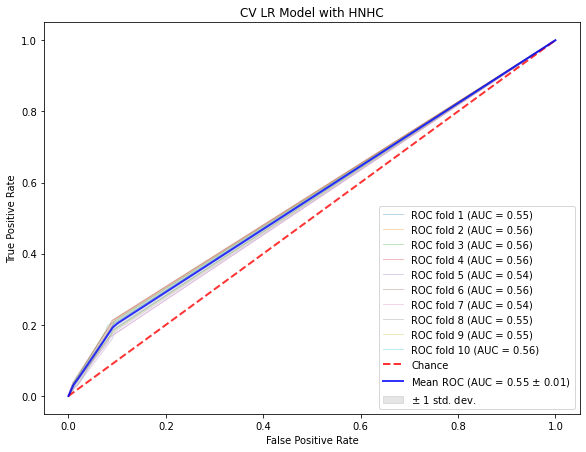

In [33]:
# Subfolder where plots/charts will be saved.
PATH_SUB = f'{images_folder}/{num_features}_features'

# If the folder already exists, pass through. If the folder does not exist, create the folder.
if path.exists(PATH_SUB):
    # Pass through.
    pass
else:
    # Create a folder to save plots/charts in. 
    os.makedirs(f'{images_folder}/{num_features}_features')

# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
draw_cv_auc_roc(model_lr_hnhc, cv, cleaned_data_wo_outcome_df_lr_hnhc, target_srs_lr_hnhc, 'CV LR Model with HNHC', num_features)

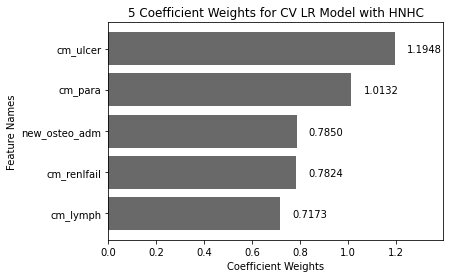

In [34]:
# Grab the feature importance using the Logistic Regression model
for value in model_lr_hnhc.coef_:
    importance_lr_hnhc = sorted(zip(value, X_train_lr_hnhc))

# Graph feature importance for Logistic Regression
value_labels_lr_hnhc = [x[0] for x in importance_lr_hnhc]
feature_names_lr_hnhc = [y[1] for y in importance_lr_hnhc]
plt.barh(feature_names_lr_hnhc, value_labels_lr_hnhc, color='dimgray')
for index, value in enumerate(value_labels_lr_hnhc):
    plt.text(value/value_labels_lr_hnhc[index]+value-0.95, index-0.09, str(f'{value:.4f}'), color='black')
plt.xlabel('Coefficient Weights')
plt.xlim((0, max(value_labels_lr_hnhc)+0.2))
plt.ylabel('Feature Names')
plt.title(f'{num_features} Coefficient Weights for CV LR Model with HNHC')
plt.savefig(f'images\{num_features}_features\CV_LR_HNHC_Coefficient_Weights_{num_features}', dpi=300)
plt.show()

## Logistic Regression RFE - HNHC without 'los' <a class="anchor" id="lrhnhcwolos"></a> 

[Return to Table of Contents](#contents)

In [35]:
# Use Recursive Feature Elimination (RFE) to select the 5 most important features with Logistic Regression
model_lr_hnhc_no_los = LogisticRegression(random_state = 42)
X_hnhc_no_los = cleaned_data_wo_outcome_hnhc_no_los
dataset_hnhc_no_los = cleaned_data_hnhc_no_los

cleaned_data_wo_outcome_df_lr_hnhc_no_los, target_srs_lr_hnhc_no_los = rfe_feature_selection(model_lr_hnhc_no_los, num_features, X_hnhc_no_los, y_hnhc, dataset_hnhc_no_los, target_hnhc, readmission_df)

['severe_IBD_hospitalization' 'cm_lymph' 'cm_ulcer' 'pq1_dm_short'
 'new_meningitis_adm']


       hnhc_patients  severe_IBD_hospitalization  cm_lymph  cm_ulcer  \
0                  0                           0         0         0   
3                  0                           0         0         0   
4                  1                           0         0         0   
9                  0                           0         0         0   
10                 0                           0         0         0   
...              ...                         ...       ...       ...   
94491              0                           0         0         0   
94492              0                           0         0         0   
94493              1                           1         0         0   
94496              0                           0         0         0   
94497              0                           0         0         0   

       pq1_dm_short  new_meningitis_adm  
0

In [36]:
# Initial model with Logistic Regression
X_train_lr_hnhc_no_los, X_test_lr_hnhc_no_los, y_train_lr_hnhc_no_los, y_test_lr_hnhc_no_los = train_test_split(cleaned_data_wo_outcome_df_lr_hnhc_no_los, target_srs_lr_hnhc_no_los, random_state=42)
model_lr_hnhc_no_los.fit(X_train_lr_hnhc_no_los, y_train_lr_hnhc_no_los)
print(f'Training Score: {model_lr_hnhc_no_los.score(X_train_lr_hnhc_no_los, y_train_lr_hnhc_no_los)}')
print(f'Testing Score: {model_lr_hnhc_no_los.score(X_test_lr_hnhc_no_los, y_test_lr_hnhc_no_los)}')

Training Score: 0.8994964979888048
Testing Score: 0.9031305375073834


In [37]:
# K-Fold Validation using Logistic Regression
scores_lr_hnhc_no_los = cross_validate(model_lr_hnhc_no_los, cleaned_data_wo_outcome_df_lr_hnhc_no_los, target_srs_lr_hnhc_no_los, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df_lr_hnhc_no_los = pd.DataFrame(scores_lr_hnhc_no_los)
scores_df_lr_hnhc_no_los

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.128049,0.009475,0.702654,0.707453,0.000000,0.250000,0.000000,0.000471,0.900443,0.900401
1,0.092448,0.007764,0.674038,0.710627,0.307692,0.536232,0.008475,0.008716,0.899388,0.900612
2,0.097278,0.007979,0.695857,0.708205,0.000000,0.250000,0.000000,0.000471,0.900633,0.900380
3,0.118981,0.008105,0.730965,0.704303,0.000000,0.285714,0.000000,0.000471,0.900422,0.900403
4,0.092149,0.008254,0.712937,0.706305,0.000000,0.538462,0.000000,0.001649,0.900422,0.900497
5,0.094362,0.007979,0.720138,0.705507,0.000000,0.285714,0.000000,0.000471,0.900211,0.900427
6,0.100303,0.007979,0.720845,0.705422,0.200000,0.515625,0.002119,0.007774,0.899789,0.900544
7,0.102725,0.008976,0.695693,0.708220,0.000000,0.000000,0.000000,0.000000,0.900422,0.900473
8,0.079683,0.006982,0.705897,0.707085,0.444444,0.500000,0.008475,0.007067,0.900211,0.900497
9,0.115679,0.007980,0.710577,0.706568,0.000000,0.400000,0.000000,0.000471,0.899789,0.900473


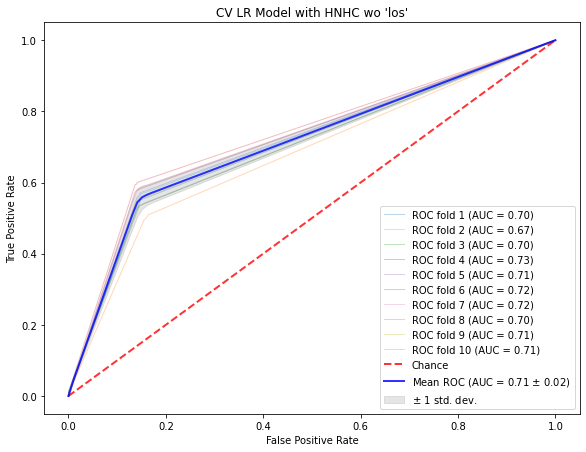

In [38]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model_lr_hnhc_no_los, cv, cleaned_data_wo_outcome_df_lr_hnhc_no_los, target_srs_lr_hnhc_no_los, "CV LR Model with HNHC wo 'los'", num_features)

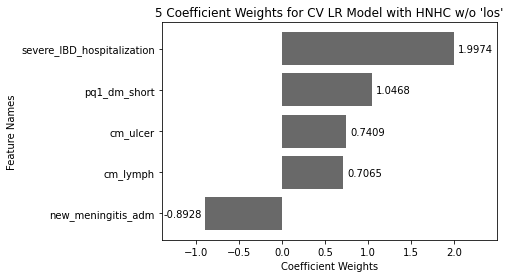

In [39]:
# Grab the feature importance using the Logistic Regression model
for value in model_lr_hnhc_no_los.coef_:
    importance_lr_hnhc_no_los = sorted(zip(value, X_train_lr_hnhc_no_los))

# Graph feature importance for Logistic Regression
value_labels_lr_hnhc_no_los = [x[0] for x in importance_lr_hnhc_no_los]
feature_names_lr_hnhc_no_los = [y[1] for y in importance_lr_hnhc_no_los]
plt.barh(feature_names_lr_hnhc_no_los, value_labels_lr_hnhc_no_los, color='dimgray')
for index, value in enumerate(value_labels_lr_hnhc_no_los):
    if value_labels_lr_hnhc_no_los[index] >= 0:
        plt.text(value/value_labels_lr_hnhc_no_los[index]+value-0.95, index-0.09, str(f'{value:.4f}'), color='black')
    elif value_labels_lr_hnhc_no_los[index] < 0:
        plt.text(-value/value_labels_lr_hnhc_no_los[index]+value+0.52, index-0.09, str(f'{value:.4f}'), color='black')
plt.xlabel('Coefficient Weights')
plt.xlim((min(value_labels_lr_hnhc_no_los)-0.5, max(value_labels_lr_hnhc_no_los)+0.5))
plt.ylabel('Feature Names')
plt.title(f"{num_features} Coefficient Weights for CV LR Model with HNHC w/o 'los'")
plt.savefig(f'images\{num_features}_features\CV_LR_HNHC_no_los_Coefficient_Weights_{num_features}', dpi=300)
plt.show()

## Decision Tree Classifier RFE - HNHC <a class="anchor" id="dtchnhc"></a> 

[Return to Table of Contents](#contents)

In [40]:
# Use Recursive Feature Elimination (RFE) to select the 5 most important features with Decision Tree Classifier
model_dtc_hnhc = DecisionTreeClassifier(random_state = 42, splitter = "best", max_depth = 5)

cleaned_data_wo_outcome_df_dtc_hnhc, target_srs_dtc_hnhc = rfe_feature_selection(model_dtc_hnhc, num_features, X_hnhc, y_hnhc, dataset_hnhc, target_hnhc, readmission_df)

['age' 'los' 'orproc' 'cc_index' 'frailty_risk_score']


       hnhc_patients  age  los  orproc  cc_index  frailty_risk_score
0                  0   89    4       0         2                 4.7
3                  0   48    4       1         0                 0.5
4                  1   65    5       0         0                 5.7
9                  0   51    3       1         0                 2.8
10                 0   22    6       1         0                 3.8
...              ...  ...  ...     ...       ...                 ...
94491              0   32    3       0         0                 0.0
94492              0   54    4       1         0                 0.0
94493              1   44    9       1         0                 0.0
94496              0   52    2       1         2                 1.5
94497              0   72    4       0         1                 4.7

[47402 rows x 6 columns]




In [41]:
# Initial model with Decision Tree Classifier
X_train_dtc_hnhc, X_test_dtc_hnhc, y_train_dtc_hnhc, y_test_dtc_hnhc = train_test_split(cleaned_data_wo_outcome_df_dtc_hnhc, target_srs_dtc_hnhc, random_state=42)
model_dtc_hnhc.fit(X_train_dtc_hnhc, y_train_dtc_hnhc)
print(f'Training Score: {model_dtc_hnhc.score(X_train_dtc_hnhc, y_train_dtc_hnhc)}')
print(f'Testing Score: {model_dtc_hnhc.score(X_test_dtc_hnhc, y_test_dtc_hnhc)}')

Training Score: 0.9179207335939917
Testing Score: 0.9189097966416336


In [42]:
# K-Fold Validation using Decision Tree Classifier
scores_dtc_hnhc = cross_validate(model_dtc_hnhc, cleaned_data_wo_outcome_df_dtc_hnhc, target_srs_dtc_hnhc, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df_dtc_hnhc = pd.DataFrame(scores_dtc_hnhc)
scores_df_dtc_hnhc

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.030913,0.007320,0.784277,0.792134,0.826087,0.829392,0.201271,0.231331,0.916262,0.918778
1,0.031538,0.006997,0.769643,0.794376,0.766990,0.846491,0.167373,0.227326,0.912044,0.919013
2,0.032314,0.003088,0.777431,0.793744,0.821138,0.877953,0.214437,0.210080,0.917300,0.918475
3,0.015616,0.019839,0.805567,0.790215,0.849624,0.843666,0.239915,0.221149,0.920253,0.918405
4,0.020344,0.010201,0.780268,0.793575,0.809091,0.873226,0.188960,0.217381,0.914979,0.918968
5,0.025479,0.002110,0.795225,0.790994,0.858333,0.853432,0.218220,0.216726,0.918565,0.918358
6,0.030120,0.007584,0.786877,0.792133,0.760274,0.784819,0.235169,0.250883,0.916456,0.918616
7,0.028318,0.005113,0.771581,0.790076,0.800000,0.772792,0.262712,0.255595,0.920042,0.918452
8,0.027141,0.002121,0.787195,0.791433,0.767296,0.797692,0.258475,0.244287,0.918354,0.918640
9,0.025668,0.007575,0.788717,0.790595,0.776224,0.830523,0.235169,0.232038,0.917089,0.918874


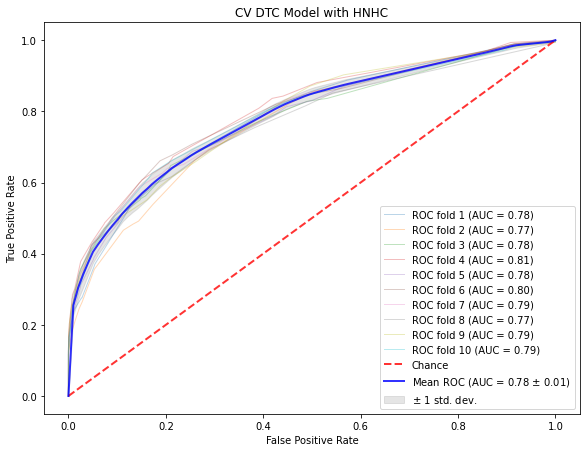

In [43]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model_dtc_hnhc, cv, cleaned_data_wo_outcome_df_dtc_hnhc, target_srs_dtc_hnhc, 'CV DTC Model with HNHC', num_features)

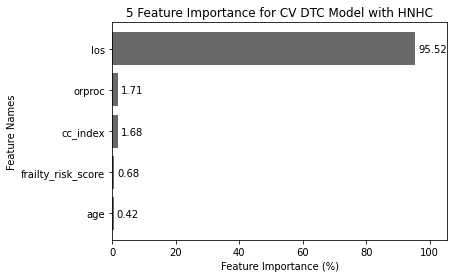

In [44]:
# Grab the feature importance using the cross validation Decision Tree Classifier model
importance_dtc_hnhc = sorted(zip(model_dtc_hnhc.feature_importances_*100, X_train_dtc_hnhc))

# Graph feature importance for Decision Tree Classifier
value_labels_dtc_hnhc = [x[0] for x in importance_dtc_hnhc]
feature_names_dtc_hnhc = [y[1] for y in importance_dtc_hnhc]
plt.barh(feature_names_dtc_hnhc, value_labels_dtc_hnhc, color='dimgray')
for index, value in enumerate(value_labels_dtc_hnhc):
    plt.text(value/value_labels_dtc_hnhc[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels_dtc_hnhc)+10))
plt.ylabel('Feature Names')
plt.title(f'{num_features} Feature Importance for CV DTC Model with HNHC')
plt.savefig(f'images\{num_features}_features\CV_DTC_HNHC_Feature_Importance_{num_features}', dpi=300)
plt.show()

## Decision Tree Classifier RFE - HNHC without 'los' <a class="anchor" id="dtchnhcwolos"></a> 

[Return to Table of Contents](#contents)

In [45]:
# Use Recursive Feature Elimination (RFE) to select the 5 most important features with Decision Tree Classifier
model_dtc_hnhc_no_los = DecisionTreeClassifier(random_state = 42, splitter = "best", max_depth = 5)

cleaned_data_wo_outcome_df_dtc_hnhc_no_los, target_srs_dtc_hnhc_no_los = rfe_feature_selection(model_dtc_hnhc_no_los, num_features, X_hnhc_no_los, y_hnhc, dataset_hnhc_no_los, target_hnhc, readmission_df)

['age' 'orproc' 'severe_IBD_hospitalization' 'blood_transfusion'
 'frailty_risk_score']


       hnhc_patients  age  orproc  severe_IBD_hospitalization  \
0                  0   89       0                           0   
3                  0   48       1                           0   
4                  1   65       0                           0   
9                  0   51       1                           0   
10                 0   22       1                           0   
...              ...  ...     ...                         ...   
94491              0   32       0                           0   
94492              0   54       1                           0   
94493              1   44       1                           1   
94496              0   52       1                           0   
94497              0   72       0                           0   

       blood_transfusion  frailty_risk_score  
0                      0                 4.7  
3                      0           

In [46]:
# Initial model with Decision Tree Classifier
X_train_dtc_hnhc_no_los, X_test_dtc_hnhc_no_los, y_train_dtc_hnhc_no_los, y_test_dtc_hnhc_no_los = train_test_split(cleaned_data_wo_outcome_df_dtc_hnhc_no_los, target_srs_dtc_hnhc_no_los, random_state=42)
model_dtc_hnhc_no_los.fit(X_train_dtc_hnhc_no_los, y_train_dtc_hnhc_no_los)
print(f'Training Score: {model_dtc_hnhc_no_los.score(X_train_dtc_hnhc_no_los, y_train_dtc_hnhc_no_los)}')
print(f'Testing Score: {model_dtc_hnhc_no_los.score(X_test_dtc_hnhc_no_los, y_test_dtc_hnhc_no_los)}')

Training Score: 0.9016624004950634
Testing Score: 0.9038055860264956


In [47]:
# K-Fold Validation using Decision Tree Classifier
scores_dtc_hnhc_no_los = cross_validate(model_dtc_hnhc_no_los, cleaned_data_wo_outcome_df_dtc_hnhc_no_los, target_srs_dtc_hnhc_no_los, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df_dtc_hnhc_no_los = pd.DataFrame(scores_dtc_hnhc_no_los)
scores_df_dtc_hnhc_no_los

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.031920,0.008806,0.749071,0.760788,0.478873,0.563553,0.072034,0.086690,0.899810,0.902440
1,0.021411,0.007974,0.724249,0.763290,0.390244,0.651724,0.033898,0.044523,0.898545,0.902557
2,0.032861,0.007015,0.740525,0.759820,0.513158,0.556589,0.082803,0.084550,0.901055,0.902185
3,0.019130,0.015625,0.766995,0.758500,0.656250,0.615385,0.044586,0.047103,0.902743,0.902231
4,0.031247,0.000000,0.737003,0.761651,0.600000,0.575318,0.063694,0.074659,0.902743,0.902419
5,0.015535,0.010171,0.766488,0.758185,0.483871,0.633333,0.031780,0.044759,0.900211,0.902372
6,0.016831,0.012276,0.774075,0.758438,0.565217,0.668269,0.027542,0.032744,0.901055,0.902138
7,0.030161,0.008975,0.751551,0.759814,0.722222,0.651584,0.027542,0.033922,0.902110,0.902067
8,0.021032,0.010166,0.743699,0.761166,0.550562,0.562865,0.103814,0.090695,0.902321,0.902513
9,0.020344,0.006754,0.767597,0.758615,0.521127,0.558304,0.078390,0.074441,0.901055,0.902044


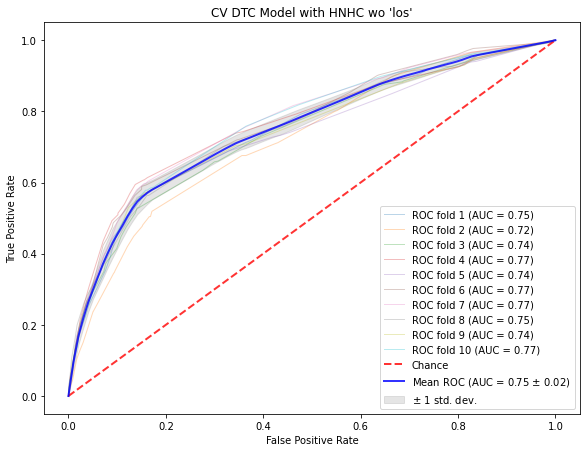

In [48]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model_dtc_hnhc_no_los, cv, cleaned_data_wo_outcome_df_dtc_hnhc_no_los, target_srs_dtc_hnhc_no_los, "CV DTC Model with HNHC wo 'los'", num_features)

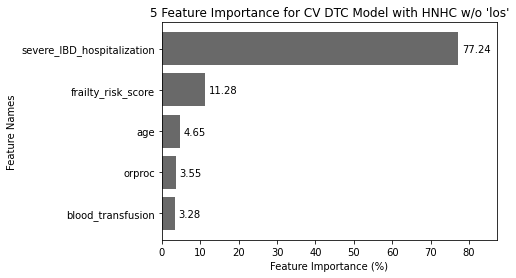

In [49]:
# Grab the feature importance using the cross validation Decision Tree Classifier model
importance_dtc_hnhc_no_los = sorted(zip(model_dtc_hnhc_no_los.feature_importances_*100, X_train_dtc_hnhc_no_los))

# Graph feature importance for Decision Tree Classifier
value_labels_dtc_hnhc_no_los = [x[0] for x in importance_dtc_hnhc_no_los]
feature_names_dtc_hnhc_no_los = [y[1] for y in importance_dtc_hnhc_no_los]
plt.barh(feature_names_dtc_hnhc_no_los, value_labels_dtc_hnhc_no_los, color='dimgray')
for index, value in enumerate(value_labels_dtc_hnhc_no_los):
    plt.text(value/value_labels_dtc_hnhc_no_los[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels_dtc_hnhc_no_los)+10))
plt.ylabel('Feature Names')
plt.title(f"{num_features} Feature Importance for CV DTC Model with HNHC w/o 'los'")
plt.savefig(f'images\{num_features}_features\CV_DTC_HNHC_no_los_Feature_Importance_{num_features}', dpi=300)
plt.show()

## XGBoost Classifier RFE - HNHC <a class="anchor" id="xgbchnhc"></a>

[Return to Table of Contents](#contents)

In [81]:
# Use Recursive Feature Elimination (RFE) to select the 5 most important features with XGBClassifier
model_xgbc_hnhc = XGBClassifier(random_state = 42, verbosity = 0, max_depth = 5)

cleaned_data_wo_outcome_df_xgbc_hnhc, target_srs_xgbc_hnhc = rfe_feature_selection(model_xgbc_hnhc, num_features, X_hnhc, y_hnhc, dataset_hnhc, target_hnhc, readmission_df)

['los' 'orproc' 'cm_dmcx' 'cm_drug' 'chronic_pain']


       hnhc_patients  los  orproc  cm_dmcx  cm_drug  chronic_pain
0                  0    4       0        0        0             0
3                  0    4       1        0        0             0
4                  1    5       0        0        0             0
9                  0    3       1        0        0             0
10                 0    6       1        0        0             0
...              ...  ...     ...      ...      ...           ...
94491              0    3       0        0        0             0
94492              0    4       1        0        0             0
94493              1    9       1        0        0             0
94496              0    2       1        0        0             0
94497              0    4       0        0        0             0

[47402 rows x 6 columns]




In [82]:
# Initial model with XGBClassifier
X_train_xgbc_hnhc, X_test_xgbc_hnhc, y_train_xgbc_hnhc, y_test_xgbc_hnhc = train_test_split(cleaned_data_wo_outcome_df_xgbc_hnhc, target_srs_xgbc_hnhc, random_state=42)
model_xgbc_hnhc.fit(X_train_xgbc_hnhc, y_train_xgbc_hnhc)
print(f'Training Score: {model_xgbc_hnhc.score(X_train_xgbc_hnhc, y_train_xgbc_hnhc)}')
print(f'Testing Score: {model_xgbc_hnhc.score(X_test_xgbc_hnhc, y_test_xgbc_hnhc)}')

Training Score: 0.9185676914854716
Testing Score: 0.9204286558096363


In [83]:
# K-Fold Validation using XGBClassifier
scores_xgbc_hnhc = cross_validate(model_xgbc_hnhc, cleaned_data_wo_outcome_df_xgbc_hnhc, target_srs_xgbc_hnhc, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df_xgbc_hnhc = pd.DataFrame(scores_xgbc_hnhc)
scores_df_xgbc_hnhc

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.609579,0.022970,0.786856,0.796943,0.808333,0.846088,0.205508,0.231802,0.916051,0.919364
1,0.605012,0.024933,0.769520,0.798850,0.754386,0.830645,0.182203,0.242638,0.912677,0.919716
2,0.588967,0.019588,0.774488,0.798385,0.816176,0.847502,0.235669,0.227744,0.918776,0.919061
3,0.608024,0.019925,0.807905,0.794947,0.829787,0.848404,0.248408,0.225389,0.920253,0.918897
4,0.592525,0.023535,0.787211,0.796986,0.800000,0.845431,0.195329,0.233161,0.915190,0.919437
5,0.604468,0.021940,0.798941,0.795542,0.820896,0.831650,0.233051,0.232744,0.918565,0.918968
6,0.587232,0.018953,0.805064,0.795142,0.848000,0.845754,0.224576,0.229918,0.918776,0.919202
7,0.596817,0.021156,0.784272,0.797514,0.849624,0.823529,0.239407,0.234158,0.920042,0.918804
8,0.594181,0.022823,0.793224,0.796656,0.816327,0.846086,0.254237,0.226620,0.920042,0.918944
9,0.584279,0.023830,0.801692,0.795243,0.820144,0.851064,0.241525,0.226148,0.919198,0.919061


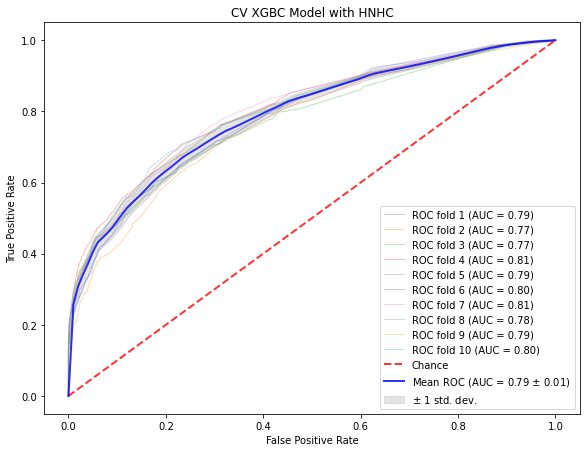

In [84]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model_xgbc_hnhc, cv, cleaned_data_wo_outcome_df_xgbc_hnhc, target_srs_xgbc_hnhc, 'CV XGBC Model with HNHC', num_features)

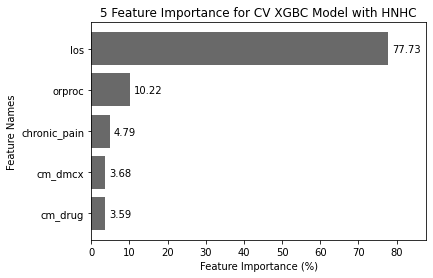

In [85]:
# Grab the feature importance using the cross validation XGBClassifier model
importance_xgbc_hnhc = sorted(zip(model_xgbc_hnhc.feature_importances_*100, X_train_xgbc_hnhc))

# Graph feature importance for XGBClassifier
value_labels_xgbc_hnhc = [x[0] for x in importance_xgbc_hnhc]
feature_names_xgbc_hnhc = [y[1] for y in importance_xgbc_hnhc]
plt.barh(feature_names_xgbc_hnhc, value_labels_xgbc_hnhc, color='dimgray')
for index, value in enumerate(value_labels_xgbc_hnhc):
    plt.text(value/value_labels_xgbc_hnhc[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels_xgbc_hnhc)+10))
plt.ylabel('Feature Names')
plt.title(f'{num_features} Feature Importance for CV XGBC Model with HNHC')
plt.savefig(f'images\{num_features}_features\CV_XGBC_HNHC_Feature_Importance_{num_features}', dpi=300)
plt.show()

## XGBoost Classifier RFE - HNHC without 'los' <a class="anchor" id="xgbchnhcwolos"></a>

[Return to Table of Contents](#contents)

In [86]:
# Use Recursive Feature Elimination (RFE) to select the 5 most important features with XGBClassifier
model_xgbc_hnhc_no_los = XGBClassifier(random_state = 42, verbosity = 0, max_depth = 5)

cleaned_data_wo_outcome_df_xgbc_hnhc_no_los, target_srs_xgbc_hnhc_no_los = rfe_feature_selection(model_xgbc_hnhc_no_los, num_features, X_hnhc_no_los, y_hnhc, dataset_hnhc_no_los, target_hnhc, readmission_df)

['orproc' 'payer' 'severe_IBD_hospitalization' 'cm_wghtloss'
 'blood_transfusion']


       hnhc_patients  orproc  payer  severe_IBD_hospitalization  cm_wghtloss  \
0                  0       0    1.0                           0            0   
3                  0       1    2.0                           0            0   
4                  1       0    1.0                           0            0   
9                  0       1    2.0                           0            0   
10                 0       1    1.0                           0            0   
...              ...     ...    ...                         ...          ...   
94491              0       0    2.0                           0            0   
94492              0       1    2.0                           0            0   
94493              1       1    2.0                           1            0   
94496              0       1    1.0                           0            0   
94497              0       0    1.0

In [87]:
# Initial model with XGBClassifier
X_train_xgbc_hnhc_no_los, X_test_xgbc_hnhc_no_los, y_train_xgbc_hnhc_no_los, y_test_xgbc_hnhc_no_los = train_test_split(cleaned_data_wo_outcome_df_xgbc_hnhc_no_los, target_srs_xgbc_hnhc_no_los, random_state=42)
model_xgbc_hnhc_no_los.fit(X_train_xgbc_hnhc_no_los, y_train_xgbc_hnhc_no_los)
print(f'Training Score: {model_xgbc_hnhc_no_los.score(X_train_xgbc_hnhc_no_los, y_train_xgbc_hnhc_no_los)}')
print(f'Testing Score: {model_xgbc_hnhc_no_los.score(X_test_xgbc_hnhc_no_los, y_test_xgbc_hnhc_no_los)}')

Training Score: 0.9003407394891724
Testing Score: 0.9033620544010813


In [88]:
# K-Fold Validation using XGBClassifier
scores_xgbc_hnhc_no_los = cross_validate(model_xgbc_hnhc_no_los, cleaned_data_wo_outcome_df_xgbc_hnhc_no_los, target_srs_xgbc_hnhc_no_los, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df_xgbc_hnhc_no_los = pd.DataFrame(scores_xgbc_hnhc_no_los)
scores_df_xgbc_hnhc_no_los

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.611887,0.023554,0.753464,0.759284,0.736842,0.549550,0.029724,0.028753,0.902429,0.900948
1,0.626454,0.024084,0.730930,0.761572,0.361702,0.535645,0.036093,0.065520,0.897782,0.901300
2,0.616827,0.022940,0.759011,0.758508,0.689655,0.542373,0.042463,0.030167,0.902851,0.900901
3,0.609964,0.021944,0.763066,0.758145,0.370370,0.588785,0.021231,0.029696,0.899050,0.901324
4,0.598314,0.021764,0.741001,0.760509,0.473684,0.572072,0.019108,0.029932,0.900317,0.901183
5,0.608517,0.027847,0.786405,0.755533,0.500000,0.570776,0.023305,0.029467,0.900317,0.901183
6,0.632839,0.024868,0.771506,0.757073,0.681818,0.552511,0.031780,0.028524,0.902006,0.900995
7,0.619361,0.024384,0.750257,0.759356,0.484848,0.559055,0.033898,0.033475,0.900106,0.901159
8,0.591161,0.019928,0.747006,0.759865,0.485714,0.570136,0.036017,0.029703,0.900106,0.901183
9,0.617464,0.025837,0.758473,0.758683,0.428571,0.531313,0.050955,0.061984,0.898817,0.901162


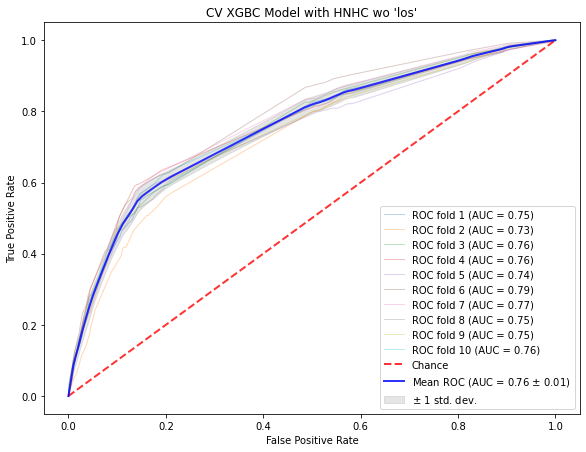

In [89]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model_xgbc_hnhc_no_los, cv, cleaned_data_wo_outcome_df_xgbc_hnhc_no_los, target_srs_xgbc_hnhc_no_los, "CV XGBC Model with HNHC wo 'los'", num_features)

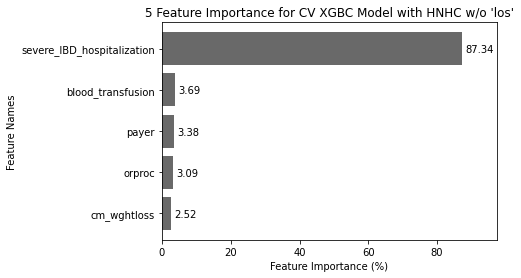

In [90]:
# Grab the feature importance using the cross validation XGBClassifier model
importance_xgbc_hnhc_no_los = sorted(zip(model_xgbc_hnhc_no_los.feature_importances_*100, X_train_xgbc_hnhc_no_los))

# Graph feature importance for XGBClassifier
value_labels_xgbc_hnhc_no_los = [x[0] for x in importance_xgbc_hnhc_no_los]
feature_names_xgbc_hnhc_no_los = [y[1] for y in importance_xgbc_hnhc_no_los] 
plt.barh(feature_names_xgbc_hnhc_no_los, value_labels_xgbc_hnhc_no_los, color='dimgray')
for index, value in enumerate(value_labels_xgbc_hnhc_no_los):
    plt.text(value/value_labels_xgbc_hnhc_no_los[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels_xgbc_hnhc_no_los)+10))
plt.ylabel('Feature Names')
plt.title(f"{num_features} Feature Importance for CV XGBC Model with HNHC w/o 'los'")
plt.savefig(f'images\{num_features}_features\CV_XGBC_HNHC_no_los_Feature_Importance_{num_features}', dpi=300)
plt.show()

## Target: IBD_READM <a class="anchor" id="ibd"></a> 

[Return to Table of Contents](#contents)

## Logistic Regression RFE - IBD_READM <a class="anchor" id="lribd"></a> 

[Return to Table of Contents](#contents)

In [60]:
# Use Recursive Feature Elimination (RFE) to select the 5 most important features with Logistic Regression
model_lr_ibd = LogisticRegression(random_state = 42)
X_ibd = cleaned_data_wo_outcome_readmit
y_ibd = target_readmit
dataset_ibd = cleaned_data_readmit
target_ibd = 'ibd_readm'

cleaned_data_wo_outcome_df_lr_ibd, target_srs_lr_ibd = rfe_feature_selection(model_lr_ibd, num_features, X_ibd, y_ibd, dataset_ibd, target_ibd, readmission_df)

['pq16_dm_amputate' 'new_cardiacarrest_adm' 'new_meningitis_adm'
 'new_atypicalmyco_adm' 'chronic_pain']


      ibd_readm  pq16_dm_amputate  new_cardiacarrest_adm  new_meningitis_adm  \
0             1                 0                      0                   0   
3             0                 0                      0                   0   
4             1                 0                      0                   0   
9             0                 0                      0                   0   
10            0                 0                      0                   0   
...         ...               ...                    ...                 ...   
94491         0                 0                      0                   0   
94492         0                 0                      0                   0   
94493         1                 0                      0                   0   
94496         0                 0                      0                   0   
94497        

In [61]:
# Initial model with Logistic Regression
X_train_lr_ibd, X_test_lr_ibd, y_train_lr_ibd, y_test_lr_ibd = train_test_split(cleaned_data_wo_outcome_df_lr_ibd, target_srs_lr_ibd, random_state=42)
model_lr_ibd.fit(X_train_lr_ibd, y_train_lr_ibd)
print(f'Training Score: {model_lr_ibd.score(X_train_lr_ibd, y_train_lr_ibd)}')
print(f'Testing Score: {model_lr_ibd.score(X_test_lr_ibd, y_test_lr_ibd)}')

Training Score: 0.588309752186999
Testing Score: 0.5973335583495064


In [62]:
# K-Fold Validation using Logistic Regression
scores_lr_ibd = cross_validate(model_lr_ibd, cleaned_data_wo_outcome_df_lr_ibd, target_srs_lr_ibd, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df_lr_ibd = pd.DataFrame(scores_lr_ibd)
scores_df_lr_ibd

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.089978,0.008956,0.505552,0.510086,0.538462,0.600192,0.024962,0.035445,0.587429,0.590914
1,0.075409,0.018815,0.512618,0.509301,0.651786,0.589041,0.037188,0.034086,0.593124,0.590282
2,0.058266,0.008332,0.509617,0.509634,0.593220,0.595472,0.035660,0.034256,0.590506,0.590572
3,0.071692,0.007087,0.510351,0.509553,0.608696,0.593719,0.035660,0.034256,0.591139,0.590502
4,0.062746,0.006716,0.510358,0.509552,0.589147,0.596020,0.038736,0.033915,0.590928,0.590526
5,0.048531,0.020301,0.508951,0.509708,0.572650,0.597837,0.034149,0.034424,0.589662,0.590666
6,0.049278,0.012443,0.507812,0.509835,0.558333,0.599606,0.034149,0.034424,0.589030,0.590736
7,0.069675,0.007092,0.508113,0.509801,0.567568,0.598240,0.032110,0.034651,0.589241,0.590713
8,0.056817,0.006982,0.510575,0.509523,0.616822,0.592989,0.033639,0.034481,0.591350,0.590479
9,0.093717,0.011600,0.512359,0.509330,0.649123,0.589216,0.037717,0.034028,0.593249,0.590268


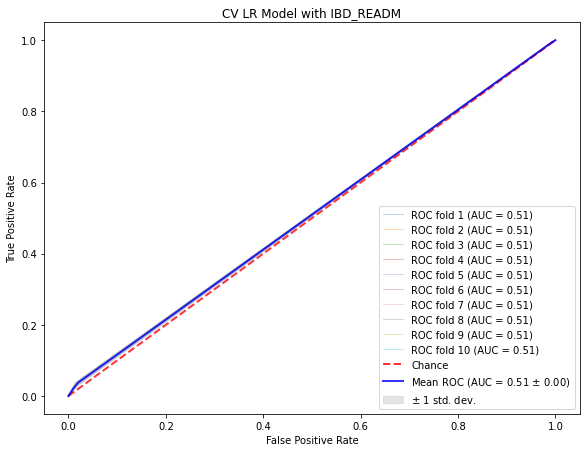

In [63]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model_lr_ibd, cv, cleaned_data_wo_outcome_df_lr_ibd, target_srs_lr_ibd, 'CV LR Model with IBD_READM', num_features)

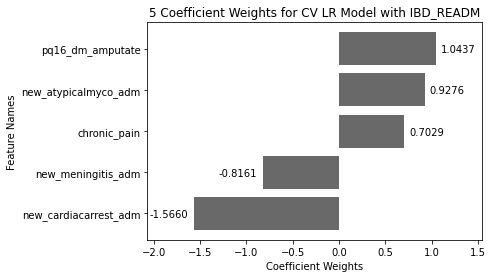

In [64]:
# Grab the feature importance using the Logistic Regression model
for value in model_lr_ibd.coef_:
    importance_lr_ibd = sorted(zip(value, X_train_lr_ibd))

# Graph feature importance for Logistic Regression
value_labels_lr_ibd = [x[0] for x in importance_lr_ibd]
feature_names_lr_ibd = [y[1] for y in importance_lr_ibd]
plt.barh(feature_names_lr_ibd, value_labels_lr_ibd, color='dimgray')
for index, value in enumerate(value_labels_lr_ibd):
    if value_labels_lr_ibd[index] >= 0:
        plt.text(value/value_labels_lr_ibd[index]+value-0.95, index-0.09, str(f'{value:.4f}'), color='black')
    elif value_labels_lr_ibd[index] < 0:
        plt.text(-value/value_labels_lr_ibd[index]+value+0.52, index-0.09, str(f'{value:.4f}'), color='black')
plt.xlabel('Coefficient Weights')
plt.xlim((min(value_labels_lr_ibd)-0.5, max(value_labels_lr_ibd)+0.5))
plt.ylabel('Feature Names')
plt.title(f"{num_features} Coefficient Weights for CV LR Model with IBD_READM")
plt.savefig(f'images\{num_features}_features\CV_LR_IBD_READM_Coefficient_Weights_{num_features}', dpi=300)
plt.show()

## Decision Tree Classifier RFE - IBD_READM <a class="anchor" id="dtcibd"></a> 

[Return to Table of Contents](#contents)

In [65]:
# Use Recursive Feature Elimination (RFE) to select the 5 most important features with Decision Tree Classifier
model_dtc_ibd = DecisionTreeClassifier(random_state = 42, splitter = "best", max_depth = 5)

cleaned_data_wo_outcome_df_dtc_ibd, target_srs_dtc_ibd = rfe_feature_selection(model_dtc_ibd, num_features, X_ibd, y_ibd, dataset_ibd, target_ibd, readmission_df)

['age' 'los' 'orproc' 'payer' 'cc_index']


      ibd_readm  age  los  orproc  payer  cc_index
0             1   89    4       0    1.0         2
3             0   48    4       1    2.0         0
4             1   65    5       0    1.0         0
9             0   51    3       1    2.0         0
10            0   22    6       1    1.0         0
...         ...  ...  ...     ...    ...       ...
94491         0   32    3       0    2.0         0
94492         0   54    4       1    2.0         0
94493         1   44    9       1    2.0         0
94496         0   52    2       1    1.0         2
94497         0   72    4       0    1.0         1

[47349 rows x 6 columns]




In [66]:
# Initial model with Decision Tree Classifier
X_train_dtc_ibd, X_test_dtc_ibd, y_train_dtc_ibd, y_test_dtc_ibd = train_test_split(cleaned_data_wo_outcome_df_dtc_ibd, target_srs_dtc_ibd, random_state=42)
model_dtc_ibd.fit(X_train_dtc_ibd, y_train_dtc_ibd)
print(f'Training Score: {model_dtc_ibd.score(X_train_dtc_ibd, y_train_dtc_ibd)}')
print(f'Testing Score: {model_dtc_ibd.score(X_test_dtc_ibd, y_test_dtc_ibd)}')

Training Score: 0.6119230660921968
Testing Score: 0.6075350565973983


In [67]:
# K-Fold Validation using Decision Tree Classifier
scores_dtc_ibd = cross_validate(model_dtc_ibd, cleaned_data_wo_outcome_df_dtc_ibd, target_srs_dtc_ibd, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df_dtc_ibd = pd.DataFrame(scores_dtc_ibd)
scores_df_dtc_ibd

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.027929,0.009169,0.610760,0.624335,0.538175,0.559658,0.294748,0.307636,0.603168,0.613179
1,0.024552,0.007179,0.614719,0.624140,0.540875,0.545430,0.334013,0.336886,0.606758,0.609260
2,0.030728,0.008189,0.618592,0.623179,0.552790,0.546321,0.328571,0.334599,0.612038,0.609495
3,0.020425,0.010234,0.625674,0.622939,0.539307,0.550867,0.325510,0.331482,0.605702,0.611348
4,0.020416,0.010227,0.619355,0.623657,0.525729,0.555081,0.312755,0.324453,0.598733,0.612663
5,0.024595,0.007654,0.617164,0.624302,0.566969,0.557064,0.287245,0.297699,0.614150,0.611255
6,0.024073,0.007097,0.609869,0.624723,0.523691,0.549494,0.321429,0.338567,0.598099,0.611255
7,0.026925,0.007947,0.622944,0.623186,0.538222,0.545715,0.352041,0.356932,0.606758,0.610762
8,0.023767,0.008798,0.631057,0.622748,0.551295,0.563273,0.271429,0.286362,0.606969,0.612639
9,0.028116,0.009376,0.606125,0.624911,0.524347,0.538910,0.379082,0.377225,0.600549,0.608565


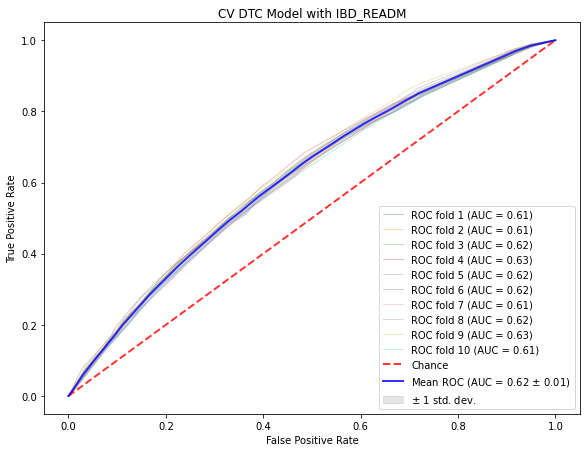

In [69]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model_dtc_ibd, cv, cleaned_data_wo_outcome_df_dtc_ibd, target_srs_dtc_ibd, 'CV DTC Model with IBD_READM', num_features)

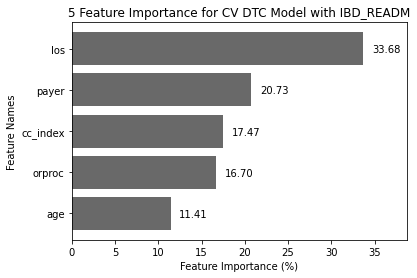

In [70]:
# Grab the feature importance using the cross validation Decision Tree Classifier model
importance_dtc_ibd = sorted(zip(model_dtc_ibd.feature_importances_*100, X_train_dtc_ibd))

# Graph feature importance for Decision Tree Classifier
value_labels_dtc_ibd = [x[0] for x in importance_dtc_ibd]
feature_names_dtc_ibd = [y[1] for y in importance_dtc_ibd]
plt.barh(feature_names_dtc_ibd, value_labels_dtc_ibd, color='dimgray')
for index, value in enumerate(value_labels_dtc_ibd):
    plt.text(value/value_labels_dtc_ibd[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels_dtc_ibd)+5))
plt.ylabel('Feature Names')
plt.title(f"{num_features} Feature Importance for CV DTC Model with IBD_READM")
plt.savefig(f'images\{num_features}_features\CV_DTC_IBD_READM_Feature_Importance_{num_features}', dpi=300)
plt.show()

## XGBoost Classifier RFE - IBD_READM <a class="anchor" id="xgbcibd"></a>

[Return to Table of Contents](#contents)

In [71]:
# Use Recursive Feature Elimination (RFE) to select the 5 most important features with XGBClassifier
model_xgbc_ibd = XGBClassifier(random_state = 42, verbosity = 0, max_depth = 5)

cleaned_data_wo_outcome_df_xgbc_ibd, target_srs_xgbc_ibd = rfe_feature_selection(model_xgbc_ibd, num_features, X_ibd, y_ibd, dataset_ibd, target_ibd, readmission_df)

['orproc' 'payer' 'cm_anemdef' 'ibd_procedures' 'chronic_pain']


      ibd_readm  orproc  payer  cm_anemdef  ibd_procedures  chronic_pain
0             1       0    1.0           1               0             0
3             0       1    2.0           0               1             0
4             1       0    1.0           1               0             0
9             0       1    2.0           0               0             0
10            0       1    1.0           0               1             0
...         ...     ...    ...         ...             ...           ...
94491         0       0    2.0           0               0             0
94492         0       1    2.0           0               1             0
94493         1       1    2.0           0               1             0
94496         0       1    1.0           0               0             0
94497         0       0    1.0           0               0             0

[47349 rows x 6 columns]




In [77]:
# Initial model with XGBClassifier
X_train_xgbc_ibd, X_test_xgbc_ibd, y_train_xgbc_ibd, y_test_xgbc_ibd = train_test_split(cleaned_data_wo_outcome_df_xgbc_ibd, target_srs_xgbc_ibd, random_state=42)
model_xgbc_ibd.fit(X_train_xgbc_ibd, y_train_xgbc_ibd)
print(f'Training Score: {model_xgbc_ibd.score(X_train_xgbc_ibd, y_train_xgbc_ibd)}')
print(f'Testing Score: {model_xgbc_ibd.score(X_test_xgbc_ibd, y_test_xgbc_ibd)}')

Training Score: 0.5988285320041677
Testing Score: 0.5959621557695557


In [78]:
# K-Fold Validation using XGBClassifier
scores_xgbc_ibd = cross_validate(model_xgbc_ibd, cleaned_data_wo_outcome_df_xgbc_ibd, target_srs_xgbc_ibd, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df_xgbc_ibd = pd.DataFrame(scores_xgbc_ibd)
scores_df_xgbc_ibd

,fit_time,score_time,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.511857,0.021785,0.587881,0.598684,0.549414,0.551044,0.167262,0.161555,0.598310,0.598418
1,0.519837,0.023926,0.603546,0.596883,0.590000,0.546316,0.180520,0.160138,0.608659,0.597269
2,0.501987,0.016958,0.607208,0.596547,0.538175,0.552529,0.147449,0.160979,0.594720,0.598676
3,0.510080,0.020790,0.604572,0.596688,0.569665,0.548865,0.164796,0.161716,0.602746,0.597926
4,0.517212,0.019040,0.589076,0.598502,0.515464,0.555994,0.153061,0.159846,0.589863,0.599334
5,0.520764,0.017981,0.586549,0.598774,0.537500,0.552093,0.153571,0.163700,0.594931,0.598794
6,0.519843,0.020881,0.591807,0.598204,0.538188,0.552028,0.154592,0.163587,0.595143,0.598770
7,0.554612,0.021849,0.591981,0.598060,0.559585,0.549693,0.165306,0.162397,0.600634,0.598160
8,0.524796,0.018951,0.598759,0.597512,0.538462,0.552256,0.157143,0.162340,0.595354,0.598723
9,0.513065,0.018809,0.590353,0.598344,0.546075,0.551738,0.163265,0.160186,0.597381,0.598451


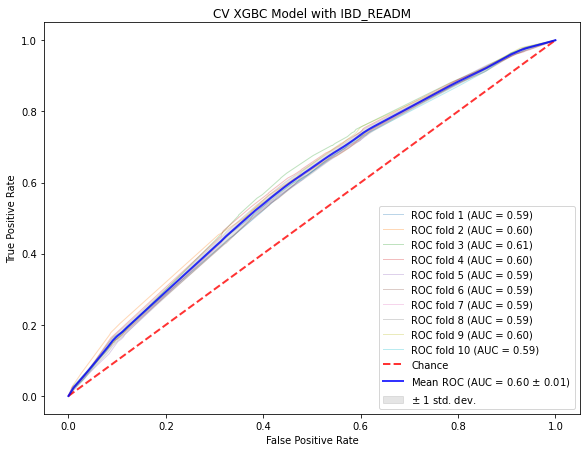

In [79]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model_xgbc_ibd, cv, cleaned_data_wo_outcome_df_xgbc_ibd, target_srs_xgbc_ibd, 'CV XGBC Model with IBD_READM', num_features)

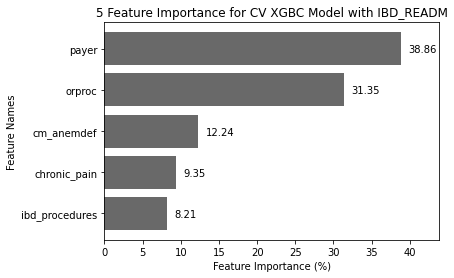

In [80]:
# Grab the feature importance using the cross validation XGBClassifier model
importance_xgbc_ibd = sorted(zip(model_xgbc_ibd.feature_importances_*100, X_train_xgbc_ibd))

# Graph feature importance for XGBClassifier
value_labels_xgbc_ibd = [x[0] for x in importance_xgbc_ibd]
feature_names_xgbc_ibd = [y[1] for y in importance_xgbc_ibd]
plt.barh(feature_names_xgbc_ibd, value_labels_xgbc_ibd, color='dimgray')
for index, value in enumerate(value_labels_xgbc_ibd):
    plt.text(value/value_labels_xgbc_ibd[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels_xgbc_ibd)+5))
plt.ylabel('Feature Names')
plt.title(f"{num_features} Feature Importance for CV XGBC Model with IBD_READM")
plt.savefig(f'images\{num_features}_features\CV_XGBC_IBD_READM_Feature_Importance_{num_features}', dpi=300)
plt.show()